In [1]:
import xgboost as xbg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import joblib

%matplotlib inline

def load_p(fname):
    return np.array(pickle.load(open(fname,"rb")))

In [2]:
X_train = load_p("/scratch/pbanerj6/sml-dataset/X_train_cls.p")
X_val = load_p("/scratch/pbanerj6/sml-dataset/X_val_cls.p")
X_test = load_p("/scratch/pbanerj6/sml-dataset/X_test_cls.p")

In [3]:
y_train = load_p("/scratch/pbanerj6/sml-dataset/y_train.p")
y_val = load_p("/scratch/pbanerj6/sml-dataset/y_val.p")
y_test = load_p("/scratch/pbanerj6/sml-dataset/y_test.p")

In [4]:
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import os

In [5]:
class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

In [6]:
train_dataset = MyDataset(X_train,y_train)
val_dataset = MyDataset(X_val,y_val)
test_dataset = MyDataset(X_test,y_test)

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=1,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=1,
    pin_memory=True
)

In [15]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.

def get_model_1():
    N, D_in, H, D_out = 32, 768, 200, 2
    return torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),)

def get_model_2():
    N , D_in, H1, H2, D_out = 32, 768, 200, 100, 2
    return torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.ReLU(),
    torch.nn.Linear(H1, H2),
    torch.nn.ReLU(),
    torch.nn.Linear(H2, D_out),)

# model = get_model_1()
# model = get_model_2()

In [9]:
# model.half()

In [10]:
def accuracy(out, labels):
    outputs = np.argmax(out, axis=1)
    return np.sum(outputs == labels)

In [17]:
def train_model(model,limit_train_examples = 100):
    patience = 20
    max_val_acc = 0.0
    model.to('cuda')
    model = torch.nn.DataParallel(model) 
    learning_rate = 1e-5
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    
    loss_fn = nn.CrossEntropyLoss()
    for t in tqdm(range(100),desc="Epoch"):
        model.train()
        total_loss = 0.0
        tmp_acc = 0.0
        steps = 0
        nb_eval_examples = 0
        for x, y in train_loader:
            if nb_eval_examples > limit_train_examples:
                continue
            steps+=1
            x=x.to('cuda')
            y=y.to('cuda')
            logits = model(x)
            loss = loss_fn(logits, y)
            logits = logits.detach().cpu().numpy()
            label_ids = y.to('cpu').numpy()
            tmp_acc += accuracy(logits, label_ids)
            # Compute and print loss.

            total_loss += loss.mean()
            # Before the backward pass, use the optimizer object to zero all of the
            # gradients for the variables it will update (which are the learnable
            # weights of the model). This is because by default, gradients are
            # accumulated in buffers( i.e, not overwritten) whenever .backward()
            # is called. Checkout docs of torch.autograd.backward for more details.
            optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model
            # parameters
            loss.backward()

            # Calling the step function on an Optimizer makes an update to its
            # parameters
            optimizer.step()
            nb_eval_examples += x.size(0)

        model.eval()
        val_acc = 0.0
        steps = 0
        nb_val_examples = 0
        for batch_idx, (x, y) in enumerate(val_loader):
            steps+=1
            x=x.to('cuda')
            y=y.to('cuda')
            logits = model(x)
            logits = logits.detach().cpu().numpy()
            label_ids = y.to('cpu').numpy()
            val_acc += accuracy(logits, label_ids)
            nb_val_examples += x.size(0)

        if max_val_acc < val_acc/nb_val_examples:
            patience = 20
            print("Saving Best Model!!")
            max_val_acc = val_acc/nb_val_examples
            model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
            output_model_file = os.path.join("/scratch/pbanerj6/sml-nn-v1", "best_model.bin")
            torch.save(model_to_save.state_dict(), output_model_file)
        else:
            patience-=1

        if patience == 0:
            print("Validation Accuracy Did Not Improve After", patience, "Epochs. Stopping.")
            break
        print("Epoch:",t,"Loss:",total_loss.item()/steps,"Train Accuracy:",(tmp_acc/nb_eval_examples),"Val Accuracy:",(val_acc/nb_val_examples))
    return max_val_acc


In [18]:
from scipy.stats import rankdata
from scipy.special import softmax

from scipy.stats import rankdata

def mrrs(out, labels):
#     print(out,labels)
    outputs = np.argmax(out,axis=1)
    mrr = 0.0 
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        mrr+=1/rank
    return mrr/len(labels)

def precision_at(out,labels,prank=1):
    count = 0
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        if rank <= prank:
            count+=1
    return count/len(labels)

def mrrwrapper(qid2c,qid2indexmap,preds_prob):
    labels = []
    out = []
    for qid in qid2c.keys():
        scores = []
        for ix in qid2indexmap[qid]:
            if len(scores) < 6:
                scores.append(preds_prob[ix][1])
        if len(scores) < 6:
            continue
        out.append(scores)
        labels.append(int(qid2c[qid]))
    return mrrs(np.array(out),labels),precision_at(np.array(out),labels,1),precision_at(np.array(out),labels,3)

def mrrVisualization(n_trainSamples,mrrScore):
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,mrrScore,label='MRR vs TrainData',marker='x')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("SVM_All_Linear_Mrr.png")
    plt.show()
    

def precisionVisualization(n_trainSamples,precisionAt1,precisionAt3):
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,precisionAt1,label='Precision@1 vs TrainData',marker='x')
    ax.plot(n_trainSamples,precisionAt3,label='Precision@3 vs TrainData',marker='o')
    plt.title("Precisions vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Precisions")
    fig.savefig("SVM_All_Linear_Precision.png")
    plt.show()

def load_ranking(fname):
    return pickle.load(open("/scratch/pbanerj6/sml-dataset/ranking_"+fname+".p","rb"))

def accuracyVisualization(n_trainSamples,valAccuracy,testAccuracy):
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,testAccuracy,label='TestAccuracy vs TrainData',marker='o')
    ax.plot(n_trainSamples,valAccuracy,label='ValAccuracy vs TrainData',marker='.')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("SVM_All_Linear_Accuracy.png")
    #plt.show()

qid2c,qid2indexmap = load_ranking("test")


def test_model(model):
    output_model_file = os.path.join("/scratch/pbanerj6/sml-nn-v1", "best_model.bin")
    model.load_state_dict(torch.load(output_model_file))
    model.eval()

    model.to('cuda')
    model = torch.nn.DataParallel(model) 
    model.eval()
    val_acc = 0.0
    steps = 0
    nb_val_examples = 0

    test_loader = DataLoader(
        test_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=1,
        pin_memory=True
    )

    all_preds = []

    for batch_idx, (x, y) in enumerate(test_loader):
        x=x.to('cuda')
        y=y.to('cuda')
        logits = model(x)
        logits = logits.detach().cpu().numpy()

        for pred in logits:
            all_preds.append(softmax(pred))

        label_ids = y.to('cpu').numpy()
        val_acc += accuracy(logits, label_ids)
        nb_val_examples += x.size(0)

    mrr = mrrwrapper(qid2c,qid2indexmap,all_preds)
    print("Test Accuracy:",(val_acc/nb_val_examples),"MRR:",(mrr))
    return val_acc/nb_val_examples,mrr[0],mrr[1],mrr[2]

In [19]:
#100 : Test Accuracy: 0.5926666666666667 MRR: (0.5170111111111132, 0.27466666666666667, 0.6733333333333333)
#200 : Test Accuracy: 0.5921333333333333 MRR: (0.5180888888888906, 0.27666666666666667, 0.6706666666666666)
# 200-100 : Test Accuracy: 0.5925333333333334 MRR: (0.5254666666666686, 0.2866666666666667, 0.6786666666666666)
# 200-100 : Test Accuracy: 0.5940666666666666 MRR: (0.5177444444444464, 0.276, 0.676)

In [20]:
# Run Orchestrator:
train_samples = [100,1000,10000,20000,50000]
val_accuracies = []
test_accuracies = []
mrr_vals = []
p1s = []
p3s = []

for train_sample in train_samples:
    model = get_model_1()
    # model = get_model_2()
    val_accuracies.append(train_model(model,train_sample))
    del model
    model = get_model_1()
    # model = get_model_2()
    test_acc,mrr,p1,p3=test_model(model)
    test_accuracies.append(test_acc)
    mrr_vals.append(mrr)
    p1s.append(p1)
    p3s.append(p3)
    del model



Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   1%|          | 1/100 [00:04<07:56,  4.82s/it]

Saving Best Model!!
Epoch: 0 Loss: 0.006112113944503036 Train Accuracy: 0.4765625 Val Accuracy: 0.5010666666666667




Epoch:   2%|▏         | 2/100 [00:09<07:48,  4.78s/it]

Saving Best Model!!
Epoch: 1 Loss: 0.005943601827885805 Train Accuracy: 0.5546875 Val Accuracy: 0.5022666666666666




Epoch:   3%|▎         | 3/100 [00:14<07:43,  4.77s/it]

Saving Best Model!!
Epoch: 2 Loss: 0.005925846506537659 Train Accuracy: 0.5078125 Val Accuracy: 0.5063333333333333




Epoch:   4%|▍         | 4/100 [00:19<08:00,  5.00s/it]

Saving Best Model!!
Epoch: 3 Loss: 0.0057964274115653944 Train Accuracy: 0.59375 Val Accuracy: 0.5091333333333333




Epoch:   5%|▌         | 5/100 [00:24<07:51,  4.97s/it]

Saving Best Model!!
Epoch: 4 Loss: 0.00583270617893764 Train Accuracy: 0.5234375 Val Accuracy: 0.5092




Epoch:   6%|▌         | 6/100 [00:29<07:48,  4.98s/it]

Saving Best Model!!
Epoch: 5 Loss: 0.0059533800397600445 Train Accuracy: 0.46875 Val Accuracy: 0.5161333333333333




Epoch:   7%|▋         | 7/100 [00:34<07:45,  5.00s/it]

Saving Best Model!!
Epoch: 6 Loss: 0.00586802262995543 Train Accuracy: 0.5703125 Val Accuracy: 0.5195333333333333




Epoch:   8%|▊         | 8/100 [00:39<07:44,  5.05s/it]

Saving Best Model!!
Epoch: 7 Loss: 0.005848914575475111 Train Accuracy: 0.5390625 Val Accuracy: 0.5214




Epoch:   9%|▉         | 9/100 [00:45<07:43,  5.10s/it]

Epoch: 8 Loss: 0.0059053791103078354 Train Accuracy: 0.5078125 Val Accuracy: 0.5208666666666667




Epoch:  10%|█         | 10/100 [00:50<07:47,  5.20s/it]

Saving Best Model!!
Epoch: 9 Loss: 0.005896026391718687 Train Accuracy: 0.5 Val Accuracy: 0.5233333333333333
Saving Best Model!!




Epoch:  11%|█         | 11/100 [00:55<07:43,  5.21s/it]

Epoch: 10 Loss: 0.005922695212781048 Train Accuracy: 0.5 Val Accuracy: 0.5256




Epoch:  12%|█▏        | 12/100 [01:00<07:32,  5.14s/it]

Saving Best Model!!
Epoch: 11 Loss: 0.005889305427892884 Train Accuracy: 0.59375 Val Accuracy: 0.5312666666666667




Epoch:  13%|█▎        | 13/100 [01:05<07:23,  5.10s/it]

Saving Best Model!!
Epoch: 12 Loss: 0.0058875876957419585 Train Accuracy: 0.5234375 Val Accuracy: 0.5331333333333333




Epoch:  14%|█▍        | 14/100 [01:11<07:21,  5.14s/it]

Saving Best Model!!
Epoch: 13 Loss: 0.0059204818343302846 Train Accuracy: 0.53125 Val Accuracy: 0.5366666666666666




Epoch:  15%|█▌        | 15/100 [01:15<07:11,  5.08s/it]

Saving Best Model!!
Epoch: 14 Loss: 0.00590541317010485 Train Accuracy: 0.5625 Val Accuracy: 0.5423333333333333




Epoch:  16%|█▌        | 16/100 [01:21<07:06,  5.08s/it]

Saving Best Model!!
Epoch: 15 Loss: 0.005881752286638532 Train Accuracy: 0.53125 Val Accuracy: 0.5452




Epoch:  17%|█▋        | 17/100 [01:26<07:05,  5.13s/it]

Epoch: 16 Loss: 0.005899571152384093 Train Accuracy: 0.4765625 Val Accuracy: 0.544




Epoch:  18%|█▊        | 18/100 [01:31<07:07,  5.21s/it]

Epoch: 17 Loss: 0.005807720521874011 Train Accuracy: 0.59375 Val Accuracy: 0.5394666666666666




Epoch:  19%|█▉        | 19/100 [01:37<07:16,  5.38s/it]

Epoch: 18 Loss: 0.005971514085716784 Train Accuracy: 0.4765625 Val Accuracy: 0.5370666666666667




Epoch:  20%|██        | 20/100 [01:43<07:29,  5.61s/it]

Epoch: 19 Loss: 0.005822671756053022 Train Accuracy: 0.5234375 Val Accuracy: 0.5381333333333334




Epoch:  21%|██        | 21/100 [01:49<07:35,  5.77s/it]

Saving Best Model!!
Epoch: 20 Loss: 0.005938335268228039 Train Accuracy: 0.515625 Val Accuracy: 0.5469333333333334




Epoch:  22%|██▏       | 22/100 [01:55<07:36,  5.85s/it]

Epoch: 21 Loss: 0.005901895860619128 Train Accuracy: 0.5078125 Val Accuracy: 0.544




Epoch:  23%|██▎       | 23/100 [02:01<07:30,  5.85s/it]

Saving Best Model!!
Epoch: 22 Loss: 0.005854652888739287 Train Accuracy: 0.5703125 Val Accuracy: 0.5532666666666667




Epoch:  24%|██▍       | 24/100 [02:07<07:28,  5.90s/it]

Saving Best Model!!
Epoch: 23 Loss: 0.005831787072773427 Train Accuracy: 0.5390625 Val Accuracy: 0.5580666666666667




Epoch:  25%|██▌       | 25/100 [02:13<07:20,  5.88s/it]

Saving Best Model!!
Epoch: 24 Loss: 0.0058742387970881675 Train Accuracy: 0.59375 Val Accuracy: 0.5598




Epoch:  26%|██▌       | 26/100 [02:19<07:16,  5.90s/it]

Saving Best Model!!
Epoch: 25 Loss: 0.005847159225040916 Train Accuracy: 0.5546875 Val Accuracy: 0.5626




Epoch:  27%|██▋       | 27/100 [02:25<07:13,  5.94s/it]

Saving Best Model!!
Epoch: 26 Loss: 0.0059093264882752634 Train Accuracy: 0.5078125 Val Accuracy: 0.5629333333333333
Saving Best Model!!




Epoch:  28%|██▊       | 28/100 [02:31<07:17,  6.08s/it]

Epoch: 27 Loss: 0.005911509873770447 Train Accuracy: 0.515625 Val Accuracy: 0.5632




Epoch:  29%|██▉       | 29/100 [02:38<07:15,  6.13s/it]

Saving Best Model!!
Epoch: 28 Loss: 0.0058380998273902356 Train Accuracy: 0.640625 Val Accuracy: 0.5666




Epoch:  30%|███       | 30/100 [02:44<07:09,  6.13s/it]

Epoch: 29 Loss: 0.005864522096190625 Train Accuracy: 0.5546875 Val Accuracy: 0.5630666666666667




Epoch:  31%|███       | 31/100 [02:50<06:59,  6.07s/it]

Epoch: 30 Loss: 0.005657914859145435 Train Accuracy: 0.65625 Val Accuracy: 0.5646666666666667
Saving Best Model!!




Epoch:  32%|███▏      | 32/100 [02:57<07:20,  6.48s/it]

Epoch: 31 Loss: 0.005827774625343046 Train Accuracy: 0.5703125 Val Accuracy: 0.5682666666666667




Epoch:  33%|███▎      | 33/100 [03:03<07:03,  6.32s/it]

Epoch: 32 Loss: 0.005803663847543029 Train Accuracy: 0.5859375 Val Accuracy: 0.5671333333333334




Epoch:  34%|███▍      | 34/100 [03:09<06:47,  6.18s/it]

Saving Best Model!!
Epoch: 33 Loss: 0.005821483221643769 Train Accuracy: 0.5859375 Val Accuracy: 0.5686666666666667




Epoch:  35%|███▌      | 35/100 [03:15<06:36,  6.09s/it]

Saving Best Model!!
Epoch: 34 Loss: 0.0058331545482058 Train Accuracy: 0.5703125 Val Accuracy: 0.5693333333333334




Epoch:  36%|███▌      | 36/100 [03:21<06:28,  6.07s/it]

Saving Best Model!!
Epoch: 35 Loss: 0.005899956485610019 Train Accuracy: 0.53125 Val Accuracy: 0.5712




Epoch:  37%|███▋      | 37/100 [03:27<06:24,  6.11s/it]

Saving Best Model!!
Epoch: 36 Loss: 0.005880281615104756 Train Accuracy: 0.5625 Val Accuracy: 0.5717333333333333




Epoch:  38%|███▊      | 38/100 [03:33<06:20,  6.13s/it]

Saving Best Model!!
Epoch: 37 Loss: 0.00579614578279605 Train Accuracy: 0.578125 Val Accuracy: 0.5738666666666666




Epoch:  39%|███▉      | 39/100 [03:39<06:13,  6.13s/it]

Epoch: 38 Loss: 0.005810655764679411 Train Accuracy: 0.5703125 Val Accuracy: 0.5690666666666667




Epoch:  40%|████      | 40/100 [03:45<06:02,  6.04s/it]

Epoch: 39 Loss: 0.005709238906404865 Train Accuracy: 0.6328125 Val Accuracy: 0.5631333333333334




Epoch:  41%|████      | 41/100 [03:51<06:00,  6.11s/it]

Saving Best Model!!
Epoch: 40 Loss: 0.005778488573997514 Train Accuracy: 0.5234375 Val Accuracy: 0.5747333333333333




Epoch:  42%|████▏     | 42/100 [03:58<05:57,  6.16s/it]

Saving Best Model!!
Epoch: 41 Loss: 0.005769127213370317 Train Accuracy: 0.6171875 Val Accuracy: 0.5804




Epoch:  43%|████▎     | 43/100 [04:04<05:51,  6.16s/it]

Saving Best Model!!
Epoch: 42 Loss: 0.005793623324396259 Train Accuracy: 0.59375 Val Accuracy: 0.5812




Epoch:  44%|████▍     | 44/100 [04:09<05:33,  5.95s/it]

Saving Best Model!!
Epoch: 43 Loss: 0.005770223735492112 Train Accuracy: 0.5625 Val Accuracy: 0.5816




Epoch:  45%|████▌     | 45/100 [04:15<05:18,  5.79s/it]

Saving Best Model!!
Epoch: 44 Loss: 0.005850515385934793 Train Accuracy: 0.546875 Val Accuracy: 0.5834666666666667




Epoch:  46%|████▌     | 46/100 [04:20<05:03,  5.63s/it]

Epoch: 45 Loss: 0.005720785685947963 Train Accuracy: 0.6171875 Val Accuracy: 0.5817333333333333




Epoch:  47%|████▋     | 47/100 [04:25<04:55,  5.58s/it]

Saving Best Model!!
Epoch: 46 Loss: 0.00577534693898931 Train Accuracy: 0.5859375 Val Accuracy: 0.5870666666666666
Saving Best Model!!




Epoch:  48%|████▊     | 48/100 [04:31<04:49,  5.57s/it]

Epoch: 47 Loss: 0.005652254324223695 Train Accuracy: 0.6328125 Val Accuracy: 0.5874666666666667




Epoch:  49%|████▉     | 49/100 [04:37<04:43,  5.56s/it]

Epoch: 48 Loss: 0.005723163771476827 Train Accuracy: 0.609375 Val Accuracy: 0.5795333333333333




Epoch:  50%|█████     | 50/100 [04:42<04:36,  5.53s/it]

Epoch: 49 Loss: 0.005619737385178425 Train Accuracy: 0.6796875 Val Accuracy: 0.5843333333333334




Epoch:  51%|█████     | 51/100 [04:47<04:28,  5.48s/it]

Epoch: 50 Loss: 0.005702555052507152 Train Accuracy: 0.6171875 Val Accuracy: 0.5862666666666667




Epoch:  52%|█████▏    | 52/100 [04:53<04:22,  5.46s/it]

Saving Best Model!!
Epoch: 51 Loss: 0.0056620640541190535 Train Accuracy: 0.640625 Val Accuracy: 0.5875333333333334




Epoch:  53%|█████▎    | 53/100 [04:58<04:15,  5.44s/it]

Saving Best Model!!
Epoch: 52 Loss: 0.0056550579030376505 Train Accuracy: 0.6640625 Val Accuracy: 0.5916666666666667




Epoch:  54%|█████▍    | 54/100 [05:03<04:08,  5.40s/it]

Epoch: 53 Loss: 0.005869181171409102 Train Accuracy: 0.578125 Val Accuracy: 0.5891333333333333




Epoch:  55%|█████▌    | 55/100 [05:09<04:02,  5.39s/it]

Saving Best Model!!
Epoch: 54 Loss: 0.005768835925852566 Train Accuracy: 0.6015625 Val Accuracy: 0.5921333333333333




Epoch:  56%|█████▌    | 56/100 [05:15<04:02,  5.51s/it]

Saving Best Model!!
Epoch: 55 Loss: 0.005548094889756713 Train Accuracy: 0.6484375 Val Accuracy: 0.5948666666666667




Epoch:  57%|█████▋    | 57/100 [05:20<03:54,  5.46s/it]

Saving Best Model!!
Epoch: 56 Loss: 0.005796277955142674 Train Accuracy: 0.59375 Val Accuracy: 0.5958666666666667




Epoch:  58%|█████▊    | 58/100 [05:26<03:50,  5.49s/it]

Epoch: 57 Loss: 0.005760189820962674 Train Accuracy: 0.546875 Val Accuracy: 0.5940666666666666




Epoch:  59%|█████▉    | 59/100 [05:31<03:43,  5.44s/it]

Epoch: 58 Loss: 0.0056877898763237735 Train Accuracy: 0.6171875 Val Accuracy: 0.5934




Epoch:  60%|██████    | 60/100 [05:36<03:38,  5.45s/it]

Epoch: 59 Loss: 0.005758224519839419 Train Accuracy: 0.5625 Val Accuracy: 0.5918




Epoch:  61%|██████    | 61/100 [05:42<03:34,  5.50s/it]

Epoch: 60 Loss: 0.00562913026382674 Train Accuracy: 0.6171875 Val Accuracy: 0.5936666666666667




Epoch:  62%|██████▏   | 62/100 [05:47<03:28,  5.48s/it]

Epoch: 61 Loss: 0.00565170377556449 Train Accuracy: 0.640625 Val Accuracy: 0.5932666666666667




Epoch:  63%|██████▎   | 63/100 [05:53<03:22,  5.47s/it]

Epoch: 62 Loss: 0.005755105252459105 Train Accuracy: 0.6328125 Val Accuracy: 0.5924666666666667




Epoch:  64%|██████▍   | 64/100 [05:58<03:14,  5.41s/it]

Epoch: 63 Loss: 0.005789948424804948 Train Accuracy: 0.6015625 Val Accuracy: 0.5928




Epoch:  65%|██████▌   | 65/100 [06:04<03:10,  5.44s/it]

Epoch: 64 Loss: 0.005687660754108225 Train Accuracy: 0.6328125 Val Accuracy: 0.5929333333333333




Epoch:  66%|██████▌   | 66/100 [06:09<03:05,  5.45s/it]

Epoch: 65 Loss: 0.005621671168280563 Train Accuracy: 0.6875 Val Accuracy: 0.5945333333333334




Epoch:  67%|██████▋   | 67/100 [06:14<02:58,  5.41s/it]

Saving Best Model!!
Epoch: 66 Loss: 0.005597037801356204 Train Accuracy: 0.65625 Val Accuracy: 0.5969333333333333
Saving Best Model!!




Epoch:  68%|██████▊   | 68/100 [06:20<02:52,  5.38s/it]

Epoch: 67 Loss: 0.005591633477444842 Train Accuracy: 0.6796875 Val Accuracy: 0.5979333333333333




Epoch:  69%|██████▉   | 69/100 [06:25<02:47,  5.39s/it]

Epoch: 68 Loss: 0.005619302233144927 Train Accuracy: 0.6171875 Val Accuracy: 0.5960666666666666




Epoch:  70%|███████   | 70/100 [06:31<02:41,  5.40s/it]

Epoch: 69 Loss: 0.005439472605170472 Train Accuracy: 0.703125 Val Accuracy: 0.5944




Epoch:  71%|███████   | 71/100 [06:36<02:35,  5.35s/it]

Epoch: 70 Loss: 0.0056845252193621736 Train Accuracy: 0.6328125 Val Accuracy: 0.5951333333333333




Epoch:  72%|███████▏  | 72/100 [06:42<02:36,  5.58s/it]

Epoch: 71 Loss: 0.005659660550831223 Train Accuracy: 0.6484375 Val Accuracy: 0.5954666666666667




Epoch:  73%|███████▎  | 73/100 [06:48<02:32,  5.65s/it]

Epoch: 72 Loss: 0.005592079813292286 Train Accuracy: 0.6484375 Val Accuracy: 0.5932




Epoch:  74%|███████▍  | 74/100 [06:54<02:29,  5.77s/it]

Epoch: 73 Loss: 0.005704722170636598 Train Accuracy: 0.578125 Val Accuracy: 0.5912666666666667




Epoch:  75%|███████▌  | 75/100 [07:00<02:26,  5.85s/it]

Epoch: 74 Loss: 0.00568273885926204 Train Accuracy: 0.640625 Val Accuracy: 0.5933333333333334




Epoch:  76%|███████▌  | 76/100 [07:06<02:19,  5.81s/it]

Epoch: 75 Loss: 0.005651854757052749 Train Accuracy: 0.6640625 Val Accuracy: 0.593




Epoch:  77%|███████▋  | 77/100 [07:12<02:16,  5.94s/it]

Epoch: 76 Loss: 0.0055665146313242314 Train Accuracy: 0.6484375 Val Accuracy: 0.5948666666666667




Epoch:  78%|███████▊  | 78/100 [07:18<02:13,  6.09s/it]

Saving Best Model!!
Epoch: 77 Loss: 0.005794628342585777 Train Accuracy: 0.5625 Val Accuracy: 0.5985333333333334




Epoch:  79%|███████▉  | 79/100 [07:24<02:08,  6.14s/it]

Epoch: 78 Loss: 0.005656595169099918 Train Accuracy: 0.640625 Val Accuracy: 0.5956




Epoch:  80%|████████  | 80/100 [07:30<02:01,  6.06s/it]

Epoch: 79 Loss: 0.005677810355798522 Train Accuracy: 0.625 Val Accuracy: 0.5964




Epoch:  81%|████████  | 81/100 [07:37<01:55,  6.10s/it]

Epoch: 80 Loss: 0.005611578284550323 Train Accuracy: 0.625 Val Accuracy: 0.5892




Epoch:  82%|████████▏ | 82/100 [07:43<01:49,  6.07s/it]

Epoch: 81 Loss: 0.005636773383947832 Train Accuracy: 0.6015625 Val Accuracy: 0.5862666666666667




Epoch:  83%|████████▎ | 83/100 [07:49<01:43,  6.08s/it]

Epoch: 82 Loss: 0.0056385175505680825 Train Accuracy: 0.6328125 Val Accuracy: 0.5830666666666666




Epoch:  84%|████████▍ | 84/100 [07:54<01:34,  5.94s/it]

Epoch: 83 Loss: 0.005487840567062151 Train Accuracy: 0.671875 Val Accuracy: 0.5844666666666667




Epoch:  85%|████████▌ | 85/100 [08:00<01:27,  5.85s/it]

Epoch: 84 Loss: 0.005337715148925781 Train Accuracy: 0.6875 Val Accuracy: 0.5856




Epoch:  86%|████████▌ | 86/100 [08:07<01:25,  6.10s/it]

Epoch: 85 Loss: 0.005543923835510384 Train Accuracy: 0.6640625 Val Accuracy: 0.5824




Epoch:  87%|████████▋ | 87/100 [08:13<01:20,  6.18s/it]

Epoch: 86 Loss: 0.005765054780028776 Train Accuracy: 0.5625 Val Accuracy: 0.5845333333333333




Epoch:  88%|████████▊ | 88/100 [08:19<01:14,  6.17s/it]

Epoch: 87 Loss: 0.005715152602205907 Train Accuracy: 0.59375 Val Accuracy: 0.5874




Epoch:  89%|████████▉ | 89/100 [08:25<01:06,  6.08s/it]

Epoch: 88 Loss: 0.005588397796728464 Train Accuracy: 0.6171875 Val Accuracy: 0.5863333333333334




Epoch:  90%|█████████ | 90/100 [08:31<01:00,  6.10s/it]

Epoch: 89 Loss: 0.005646536853521872 Train Accuracy: 0.5546875 Val Accuracy: 0.5858666666666666




Epoch:  91%|█████████ | 91/100 [08:38<00:56,  6.33s/it]

Epoch: 90 Loss: 0.00579661753640246 Train Accuracy: 0.5703125 Val Accuracy: 0.5865333333333334




Epoch:  92%|█████████▏| 92/100 [08:44<00:50,  6.37s/it]

Epoch: 91 Loss: 0.005684178521129877 Train Accuracy: 0.6015625 Val Accuracy: 0.5898




Epoch:  93%|█████████▎| 93/100 [08:51<00:44,  6.29s/it]

Epoch: 92 Loss: 0.005487642308542215 Train Accuracy: 0.671875 Val Accuracy: 0.5892666666666667




Epoch:  94%|█████████▍| 94/100 [08:57<00:37,  6.21s/it]

Epoch: 93 Loss: 0.005476132130572028 Train Accuracy: 0.6953125 Val Accuracy: 0.5892




Epoch:  95%|█████████▌| 95/100 [09:03<00:31,  6.29s/it]

Epoch: 94 Loss: 0.005578820385150055 Train Accuracy: 0.7109375 Val Accuracy: 0.5896666666666667




Epoch:  96%|█████████▌| 96/100 [09:10<00:25,  6.41s/it]

Epoch: 95 Loss: 0.005693615626678792 Train Accuracy: 0.6015625 Val Accuracy: 0.5878




Epoch:  97%|█████████▋| 97/100 [09:15<00:18,  6.19s/it]

Epoch: 96 Loss: 0.0054886895202116166 Train Accuracy: 0.6171875 Val Accuracy: 0.5887333333333333
Validation Accuracy Did Not Improve After 0 Epochs. Stopping.





Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Test Accuracy: 0.5762 MRR: (0.5232777777777788, 0.286, 0.6766666666666666)





Epoch:   1%|          | 1/100 [00:05<09:16,  5.62s/it]

Saving Best Model!!
Epoch: 0 Loss: 0.04913397587692814 Train Accuracy: 0.5087890625 Val Accuracy: 0.5188666666666667





Epoch:   2%|▏         | 2/100 [00:11<09:10,  5.62s/it]

Saving Best Model!!
Epoch: 1 Loss: 0.04685075755820854 Train Accuracy: 0.541015625 Val Accuracy: 0.5257333333333334





Epoch:   3%|▎         | 3/100 [00:16<09:05,  5.63s/it]

Saving Best Model!!
Epoch: 2 Loss: 0.046669221890252285 Train Accuracy: 0.560546875 Val Accuracy: 0.5355333333333333





Epoch:   4%|▍         | 4/100 [00:22<08:59,  5.62s/it]

Saving Best Model!!
Epoch: 3 Loss: 0.04667021013272088 Train Accuracy: 0.5546875 Val Accuracy: 0.5432666666666667





Epoch:   5%|▌         | 5/100 [00:28<09:00,  5.69s/it]

Saving Best Model!!
Epoch: 4 Loss: 0.046331791989584724 Train Accuracy: 0.5732421875 Val Accuracy: 0.5515333333333333





Epoch:   6%|▌         | 6/100 [00:34<09:06,  5.81s/it]

Saving Best Model!!
Epoch: 5 Loss: 0.045676005674577726 Train Accuracy: 0.630859375 Val Accuracy: 0.5576





Epoch:   7%|▋         | 7/100 [00:40<08:58,  5.79s/it]

Saving Best Model!!
Epoch: 6 Loss: 0.04554366252061401 Train Accuracy: 0.6064453125 Val Accuracy: 0.5627333333333333
Saving Best Model!!





Epoch:   8%|▊         | 8/100 [00:46<08:57,  5.85s/it]

Epoch: 7 Loss: 0.04530838354309993 Train Accuracy: 0.62109375 Val Accuracy: 0.57





Epoch:   9%|▉         | 9/100 [00:51<08:47,  5.80s/it]

Epoch: 8 Loss: 0.0458320259793735 Train Accuracy: 0.599609375 Val Accuracy: 0.567
Saving Best Model!!





Epoch:  10%|█         | 10/100 [00:57<08:45,  5.84s/it]

Epoch: 9 Loss: 0.045255998558581256 Train Accuracy: 0.630859375 Val Accuracy: 0.5757333333333333





Epoch:  11%|█         | 11/100 [01:04<08:50,  5.96s/it]

Saving Best Model!!
Epoch: 10 Loss: 0.044686799364557654 Train Accuracy: 0.62890625 Val Accuracy: 0.5834666666666667





Epoch:  12%|█▏        | 12/100 [01:09<08:42,  5.94s/it]

Saving Best Model!!
Epoch: 11 Loss: 0.04452149039392532 Train Accuracy: 0.6357421875 Val Accuracy: 0.584





Epoch:  13%|█▎        | 13/100 [01:15<08:38,  5.96s/it]

Epoch: 12 Loss: 0.04443742064778993 Train Accuracy: 0.6162109375 Val Accuracy: 0.5616





Epoch:  14%|█▍        | 14/100 [01:21<08:29,  5.93s/it]

Saving Best Model!!
Epoch: 13 Loss: 0.04513436339811475 Train Accuracy: 0.6142578125 Val Accuracy: 0.5896666666666667





Epoch:  15%|█▌        | 15/100 [01:27<08:20,  5.89s/it]

Saving Best Model!!
Epoch: 14 Loss: 0.045036869008403854 Train Accuracy: 0.619140625 Val Accuracy: 0.5902666666666667





Epoch:  16%|█▌        | 16/100 [01:33<08:11,  5.85s/it]

Epoch: 15 Loss: 0.044559783772873215 Train Accuracy: 0.6318359375 Val Accuracy: 0.5814666666666667





Epoch:  17%|█▋        | 17/100 [01:39<08:03,  5.82s/it]

Epoch: 16 Loss: 0.04422853140434477 Train Accuracy: 0.63671875 Val Accuracy: 0.5861333333333333





Epoch:  18%|█▊        | 18/100 [01:44<07:57,  5.83s/it]

Saving Best Model!!
Epoch: 17 Loss: 0.04454745310964361 Train Accuracy: 0.6318359375 Val Accuracy: 0.5990666666666666





Epoch:  19%|█▉        | 19/100 [01:50<07:48,  5.79s/it]

Epoch: 18 Loss: 0.04416497887324677 Train Accuracy: 0.646484375 Val Accuracy: 0.5807333333333333





Epoch:  20%|██        | 20/100 [01:56<07:40,  5.76s/it]

Epoch: 19 Loss: 0.04467841760436101 Train Accuracy: 0.6064453125 Val Accuracy: 0.5954





Epoch:  21%|██        | 21/100 [02:01<07:29,  5.70s/it]

Epoch: 20 Loss: 0.04425541322622726 Train Accuracy: 0.6298828125 Val Accuracy: 0.5938666666666667





Epoch:  22%|██▏       | 22/100 [02:07<07:25,  5.71s/it]

Epoch: 21 Loss: 0.04402373340338278 Train Accuracy: 0.626953125 Val Accuracy: 0.5798





Epoch:  23%|██▎       | 23/100 [02:13<07:17,  5.69s/it]

Saving Best Model!!
Epoch: 22 Loss: 0.04449102975158041 Train Accuracy: 0.6240234375 Val Accuracy: 0.5992





Epoch:  24%|██▍       | 24/100 [02:18<07:11,  5.67s/it]

Saving Best Model!!
Epoch: 23 Loss: 0.04437831724122135 Train Accuracy: 0.6376953125 Val Accuracy: 0.6003333333333334





Epoch:  25%|██▌       | 25/100 [02:24<07:06,  5.69s/it]

Saving Best Model!!
Epoch: 24 Loss: 0.04370761781867379 Train Accuracy: 0.6484375 Val Accuracy: 0.6048666666666667





Epoch:  26%|██▌       | 26/100 [02:30<07:10,  5.82s/it]

Saving Best Model!!
Epoch: 25 Loss: 0.044695177057912865 Train Accuracy: 0.615234375 Val Accuracy: 0.6058666666666667





Epoch:  27%|██▋       | 27/100 [02:36<07:14,  5.95s/it]

Epoch: 26 Loss: 0.043356039376655366 Train Accuracy: 0.6572265625 Val Accuracy: 0.5998666666666667
Saving Best Model!!





Epoch:  28%|██▊       | 28/100 [02:45<07:54,  6.59s/it]

Epoch: 27 Loss: 0.043735252006221685 Train Accuracy: 0.634765625 Val Accuracy: 0.6082666666666666





Epoch:  29%|██▉       | 29/100 [02:51<07:49,  6.61s/it]

Epoch: 28 Loss: 0.043499981162390476 Train Accuracy: 0.65234375 Val Accuracy: 0.6043333333333333





Epoch:  30%|███       | 30/100 [02:58<07:44,  6.63s/it]

Saving Best Model!!
Epoch: 29 Loss: 0.042917243453231196 Train Accuracy: 0.658203125 Val Accuracy: 0.6088666666666667





Epoch:  31%|███       | 31/100 [03:04<07:30,  6.52s/it]

Saving Best Model!!
Epoch: 30 Loss: 0.04328422709060376 Train Accuracy: 0.64453125 Val Accuracy: 0.6092666666666666





Epoch:  32%|███▏      | 32/100 [03:11<07:21,  6.49s/it]

Epoch: 31 Loss: 0.043445827101847766 Train Accuracy: 0.6484375 Val Accuracy: 0.5952





Epoch:  33%|███▎      | 33/100 [03:17<07:11,  6.44s/it]

Saving Best Model!!
Epoch: 32 Loss: 0.04285823358401561 Train Accuracy: 0.66015625 Val Accuracy: 0.6109333333333333





Epoch:  34%|███▍      | 34/100 [03:24<07:09,  6.51s/it]

Epoch: 33 Loss: 0.044129007660758016 Train Accuracy: 0.6123046875 Val Accuracy: 0.6038





Epoch:  35%|███▌      | 35/100 [03:30<07:07,  6.58s/it]

Saving Best Model!!
Epoch: 34 Loss: 0.0425115516190844 Train Accuracy: 0.6669921875 Val Accuracy: 0.6145333333333334





Epoch:  36%|███▌      | 36/100 [03:37<06:59,  6.55s/it]

Epoch: 35 Loss: 0.04292236360659731 Train Accuracy: 0.6572265625 Val Accuracy: 0.6118666666666667





Epoch:  37%|███▋      | 37/100 [03:43<06:48,  6.48s/it]

Epoch: 36 Loss: 0.04240954710222256 Train Accuracy: 0.66796875 Val Accuracy: 0.6064666666666667





Epoch:  38%|███▊      | 38/100 [03:49<06:37,  6.41s/it]

Epoch: 37 Loss: 0.042904070953824626 Train Accuracy: 0.6416015625 Val Accuracy: 0.6126666666666667





Epoch:  39%|███▉      | 39/100 [03:56<06:28,  6.37s/it]

Epoch: 38 Loss: 0.04335329425868703 Train Accuracy: 0.6484375 Val Accuracy: 0.613





Epoch:  40%|████      | 40/100 [04:02<06:28,  6.47s/it]

Epoch: 39 Loss: 0.043369919506471545 Train Accuracy: 0.62109375 Val Accuracy: 0.6108





Epoch:  41%|████      | 41/100 [04:09<06:29,  6.60s/it]

Epoch: 40 Loss: 0.04227087187614522 Train Accuracy: 0.666015625 Val Accuracy: 0.6093333333333333





Epoch:  42%|████▏     | 42/100 [04:16<06:18,  6.53s/it]

Epoch: 41 Loss: 0.042838342662559134 Train Accuracy: 0.658203125 Val Accuracy: 0.613





Epoch:  43%|████▎     | 43/100 [04:22<06:09,  6.48s/it]

Epoch: 42 Loss: 0.04283168930997218 Train Accuracy: 0.6513671875 Val Accuracy: 0.6133333333333333





Epoch:  44%|████▍     | 44/100 [04:28<05:59,  6.41s/it]

Saving Best Model!!
Epoch: 43 Loss: 0.04241114537090635 Train Accuracy: 0.6494140625 Val Accuracy: 0.6152666666666666





Epoch:  45%|████▌     | 45/100 [04:35<05:53,  6.43s/it]

Epoch: 44 Loss: 0.04265419608240188 Train Accuracy: 0.6455078125 Val Accuracy: 0.6144





Epoch:  46%|████▌     | 46/100 [04:41<05:53,  6.54s/it]

Epoch: 45 Loss: 0.04193193724414687 Train Accuracy: 0.658203125 Val Accuracy: 0.6142666666666666





Epoch:  47%|████▋     | 47/100 [04:48<05:49,  6.60s/it]

Epoch: 46 Loss: 0.04309577779220874 Train Accuracy: 0.6640625 Val Accuracy: 0.6129333333333333





Epoch:  48%|████▊     | 48/100 [04:55<05:45,  6.65s/it]

Saving Best Model!!
Epoch: 47 Loss: 0.04207779044535623 Train Accuracy: 0.671875 Val Accuracy: 0.6176





Epoch:  49%|████▉     | 49/100 [05:02<05:40,  6.67s/it]

Saving Best Model!!
Epoch: 48 Loss: 0.04313096817114206 Train Accuracy: 0.654296875 Val Accuracy: 0.6189333333333333





Epoch:  50%|█████     | 50/100 [05:08<05:25,  6.50s/it]

Saving Best Model!!
Epoch: 49 Loss: 0.041763533407182835 Train Accuracy: 0.6650390625 Val Accuracy: 0.619





Epoch:  51%|█████     | 51/100 [05:14<05:09,  6.31s/it]

Epoch: 50 Loss: 0.042469293069737804 Train Accuracy: 0.6728515625 Val Accuracy: 0.611





Epoch:  52%|█████▏    | 52/100 [05:19<04:54,  6.14s/it]

Epoch: 51 Loss: 0.0425537857673824 Train Accuracy: 0.6591796875 Val Accuracy: 0.614





Epoch:  53%|█████▎    | 53/100 [05:25<04:44,  6.04s/it]

Epoch: 52 Loss: 0.042933962238368706 Train Accuracy: 0.64453125 Val Accuracy: 0.6048





Epoch:  54%|█████▍    | 54/100 [05:31<04:35,  5.99s/it]

Epoch: 53 Loss: 0.041595926671139975 Train Accuracy: 0.6787109375 Val Accuracy: 0.6112666666666666





Epoch:  55%|█████▌    | 55/100 [05:37<04:27,  5.95s/it]

Epoch: 54 Loss: 0.0415608826984983 Train Accuracy: 0.6796875 Val Accuracy: 0.6114666666666667





Epoch:  56%|█████▌    | 56/100 [05:43<04:20,  5.92s/it]

Epoch: 55 Loss: 0.04147558069940823 Train Accuracy: 0.671875 Val Accuracy: 0.5971333333333333





Epoch:  57%|█████▋    | 57/100 [05:48<04:07,  5.77s/it]

Epoch: 56 Loss: 0.043139069319279716 Train Accuracy: 0.6552734375 Val Accuracy: 0.616





Epoch:  58%|█████▊    | 58/100 [05:54<04:03,  5.80s/it]

Epoch: 57 Loss: 0.043106274309951356 Train Accuracy: 0.6435546875 Val Accuracy: 0.6097333333333333





Epoch:  59%|█████▉    | 59/100 [06:00<03:57,  5.79s/it]

Epoch: 58 Loss: 0.04159827730548916 Train Accuracy: 0.685546875 Val Accuracy: 0.6152666666666666





Epoch:  60%|██████    | 60/100 [06:05<03:49,  5.73s/it]

Epoch: 59 Loss: 0.04113193259818722 Train Accuracy: 0.669921875 Val Accuracy: 0.6055333333333334





Epoch:  61%|██████    | 61/100 [06:11<03:44,  5.75s/it]

Epoch: 60 Loss: 0.04252547648415637 Train Accuracy: 0.6552734375 Val Accuracy: 0.6181333333333333





Epoch:  62%|██████▏   | 62/100 [06:17<03:40,  5.80s/it]

Epoch: 61 Loss: 0.04236441736282316 Train Accuracy: 0.6533203125 Val Accuracy: 0.6178666666666667





Epoch:  63%|██████▎   | 63/100 [06:24<03:41,  5.99s/it]

Epoch: 62 Loss: 0.04139683851555212 Train Accuracy: 0.6728515625 Val Accuracy: 0.6146





Epoch:  64%|██████▍   | 64/100 [06:29<03:32,  5.89s/it]

Epoch: 63 Loss: 0.041436181139590134 Train Accuracy: 0.68359375 Val Accuracy: 0.6136





Epoch:  65%|██████▌   | 65/100 [06:35<03:27,  5.92s/it]

Epoch: 64 Loss: 0.041794425134719815 Train Accuracy: 0.6533203125 Val Accuracy: 0.6134





Epoch:  66%|██████▌   | 66/100 [06:41<03:20,  5.89s/it]

Epoch: 65 Loss: 0.04192678455604927 Train Accuracy: 0.6572265625 Val Accuracy: 0.6142666666666666





Epoch:  67%|██████▋   | 67/100 [06:47<03:15,  5.91s/it]

Epoch: 66 Loss: 0.041604198626617885 Train Accuracy: 0.666015625 Val Accuracy: 0.6174666666666667





Epoch:  68%|██████▊   | 68/100 [06:53<03:09,  5.93s/it]

Epoch: 67 Loss: 0.041413907049053005 Train Accuracy: 0.6806640625 Val Accuracy: 0.6134





Epoch:  69%|██████▉   | 69/100 [06:59<03:03,  5.92s/it]

Epoch: 68 Loss: 0.04185622892400095 Train Accuracy: 0.6572265625 Val Accuracy: 0.6164666666666667





Epoch:  70%|███████   | 70/100 [07:05<02:57,  5.92s/it]

Saving Best Model!!
Epoch: 69 Loss: 0.041674546849753046 Train Accuracy: 0.6884765625 Val Accuracy: 0.6228





Epoch:  71%|███████   | 71/100 [07:10<02:48,  5.83s/it]

Epoch: 70 Loss: 0.04182495084652769 Train Accuracy: 0.673828125 Val Accuracy: 0.6182





Epoch:  72%|███████▏  | 72/100 [07:16<02:42,  5.82s/it]

Epoch: 71 Loss: 0.04210025974428221 Train Accuracy: 0.6728515625 Val Accuracy: 0.6222666666666666





Epoch:  73%|███████▎  | 73/100 [07:22<02:37,  5.82s/it]

Epoch: 72 Loss: 0.04201163106889867 Train Accuracy: 0.6630859375 Val Accuracy: 0.622





Epoch:  74%|███████▍  | 74/100 [07:28<02:29,  5.73s/it]

Epoch: 73 Loss: 0.0419323398614489 Train Accuracy: 0.6875 Val Accuracy: 0.6222666666666666





Epoch:  75%|███████▌  | 75/100 [07:33<02:24,  5.78s/it]

Epoch: 74 Loss: 0.042411218574052174 Train Accuracy: 0.6630859375 Val Accuracy: 0.607





Epoch:  76%|███████▌  | 76/100 [07:39<02:17,  5.75s/it]

Epoch: 75 Loss: 0.040339996565633744 Train Accuracy: 0.7109375 Val Accuracy: 0.6202666666666666





Epoch:  77%|███████▋  | 77/100 [07:45<02:12,  5.77s/it]

Epoch: 76 Loss: 0.041384288242885044 Train Accuracy: 0.6845703125 Val Accuracy: 0.6194





Epoch:  78%|███████▊  | 78/100 [07:52<02:13,  6.07s/it]

Epoch: 77 Loss: 0.041435253899743056 Train Accuracy: 0.658203125 Val Accuracy: 0.6219333333333333





Epoch:  79%|███████▉  | 79/100 [07:58<02:08,  6.10s/it]

Epoch: 78 Loss: 0.041307030456152555 Train Accuracy: 0.685546875 Val Accuracy: 0.6222666666666666





Epoch:  80%|████████  | 80/100 [08:05<02:05,  6.30s/it]

Epoch: 79 Loss: 0.04107402890984183 Train Accuracy: 0.6826171875 Val Accuracy: 0.6224666666666666





Epoch:  81%|████████  | 81/100 [08:11<02:00,  6.33s/it]

Epoch: 80 Loss: 0.04125507248998451 Train Accuracy: 0.673828125 Val Accuracy: 0.6208666666666667





Epoch:  82%|████████▏ | 82/100 [08:17<01:53,  6.31s/it]

Saving Best Model!!
Epoch: 81 Loss: 0.03996267095049307 Train Accuracy: 0.6953125 Val Accuracy: 0.6254





Epoch:  83%|████████▎ | 83/100 [08:24<01:51,  6.54s/it]

Epoch: 82 Loss: 0.04102459645220466 Train Accuracy: 0.677734375 Val Accuracy: 0.621





Epoch:  84%|████████▍ | 84/100 [08:31<01:45,  6.59s/it]

Epoch: 83 Loss: 0.04216280776554587 Train Accuracy: 0.6513671875 Val Accuracy: 0.6182666666666666





Epoch:  85%|████████▌ | 85/100 [08:38<01:38,  6.56s/it]

Epoch: 84 Loss: 0.04037088015948786 Train Accuracy: 0.693359375 Val Accuracy: 0.62





Epoch:  86%|████████▌ | 86/100 [08:44<01:31,  6.51s/it]

Epoch: 85 Loss: 0.04149976213857817 Train Accuracy: 0.673828125 Val Accuracy: 0.6225333333333334





Epoch:  87%|████████▋ | 87/100 [08:51<01:25,  6.55s/it]

Epoch: 86 Loss: 0.041678764164320696 Train Accuracy: 0.6630859375 Val Accuracy: 0.6224





Epoch:  88%|████████▊ | 88/100 [08:57<01:18,  6.56s/it]

Saving Best Model!!
Epoch: 87 Loss: 0.04176062154871568 Train Accuracy: 0.6669921875 Val Accuracy: 0.626





Epoch:  89%|████████▉ | 89/100 [09:04<01:12,  6.59s/it]

Epoch: 88 Loss: 0.04183523588851571 Train Accuracy: 0.6630859375 Val Accuracy: 0.6158666666666667





Epoch:  90%|█████████ | 90/100 [09:11<01:07,  6.71s/it]

Epoch: 89 Loss: 0.039987478683243934 Train Accuracy: 0.703125 Val Accuracy: 0.6253333333333333





Epoch:  91%|█████████ | 91/100 [09:17<01:00,  6.67s/it]

Epoch: 90 Loss: 0.040796182303032134 Train Accuracy: 0.6806640625 Val Accuracy: 0.6225333333333334
Saving Best Model!!





Epoch:  92%|█████████▏| 92/100 [09:24<00:52,  6.61s/it]

Epoch: 91 Loss: 0.041663590778928325 Train Accuracy: 0.65625 Val Accuracy: 0.6267333333333334





Epoch:  93%|█████████▎| 93/100 [09:30<00:45,  6.57s/it]

Saving Best Model!!
Epoch: 92 Loss: 0.04167491286548216 Train Accuracy: 0.654296875 Val Accuracy: 0.6282666666666666





Epoch:  94%|█████████▍| 94/100 [09:37<00:39,  6.63s/it]

Epoch: 93 Loss: 0.0405854263793685 Train Accuracy: 0.6806640625 Val Accuracy: 0.626





Epoch:  95%|█████████▌| 95/100 [09:44<00:33,  6.70s/it]

Epoch: 94 Loss: 0.04250019293095766 Train Accuracy: 0.6572265625 Val Accuracy: 0.6193333333333333





Epoch:  96%|█████████▌| 96/100 [09:51<00:26,  6.69s/it]

Epoch: 95 Loss: 0.041958026031949626 Train Accuracy: 0.662109375 Val Accuracy: 0.6142





Epoch:  97%|█████████▋| 97/100 [09:57<00:19,  6.65s/it]

Epoch: 96 Loss: 0.04063498897593159 Train Accuracy: 0.6611328125 Val Accuracy: 0.6185333333333334





Epoch:  98%|█████████▊| 98/100 [10:04<00:13,  6.66s/it]

Epoch: 97 Loss: 0.04107355308939399 Train Accuracy: 0.6669921875 Val Accuracy: 0.6246





Epoch:  99%|█████████▉| 99/100 [10:10<00:06,  6.55s/it]

Epoch: 98 Loss: 0.040643374802969666 Train Accuracy: 0.673828125 Val Accuracy: 0.6184





Epoch: 100%|██████████| 100/100 [10:16<00:00,  6.46s/it]

Epoch: 99 Loss: 0.04181096904567564 Train Accuracy: 0.6728515625 Val Accuracy: 0.619





Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Test Accuracy: 0.6218666666666667 MRR: (0.5729333333333361, 0.34, 0.7473333333333333)





Epoch:   1%|          | 1/100 [00:08<13:45,  8.33s/it]

Saving Best Model!!
Epoch: 0 Loss: 0.4519678372055737 Train Accuracy: 0.582867412140575 Val Accuracy: 0.5826





Epoch:   2%|▏         | 2/100 [00:16<13:19,  8.16s/it]

Saving Best Model!!
Epoch: 1 Loss: 0.43665045309168443 Train Accuracy: 0.6355830670926518 Val Accuracy: 0.5891333333333333





Epoch:   3%|▎         | 3/100 [00:23<12:37,  7.80s/it]

Saving Best Model!!
Epoch: 2 Loss: 0.4244250071836687 Train Accuracy: 0.6503594249201278 Val Accuracy: 0.6017333333333333





Epoch:   4%|▍         | 4/100 [00:30<12:08,  7.59s/it]

Saving Best Model!!
Epoch: 3 Loss: 0.4200838979627532 Train Accuracy: 0.6531549520766773 Val Accuracy: 0.6042
Saving Best Model!!





Epoch:   5%|▌         | 5/100 [00:37<11:49,  7.46s/it]

Epoch: 4 Loss: 0.4157308159606543 Train Accuracy: 0.6526557507987221 Val Accuracy: 0.6115333333333334





Epoch:   6%|▌         | 6/100 [00:44<11:31,  7.36s/it]

Saving Best Model!!
Epoch: 5 Loss: 0.412445068359375 Train Accuracy: 0.665435303514377 Val Accuracy: 0.6134666666666667





Epoch:   7%|▋         | 7/100 [00:51<11:18,  7.30s/it]

Saving Best Model!!
Epoch: 6 Loss: 0.4086677209654851 Train Accuracy: 0.6684305111821086 Val Accuracy: 0.6175333333333334





Epoch:   8%|▊         | 8/100 [00:58<11:11,  7.30s/it]

Epoch: 7 Loss: 0.4039719181020123 Train Accuracy: 0.6761182108626198 Val Accuracy: 0.6128





Epoch:   9%|▉         | 9/100 [01:05<10:54,  7.19s/it]

Epoch: 8 Loss: 0.4049129852099713 Train Accuracy: 0.6703274760383386 Val Accuracy: 0.6122
Saving Best Model!!





Epoch:  10%|█         | 10/100 [01:12<10:37,  7.08s/it]

Epoch: 9 Loss: 0.40560512908740337 Train Accuracy: 0.6650359424920128 Val Accuracy: 0.6189333333333333





Epoch:  11%|█         | 11/100 [01:19<10:21,  6.99s/it]

Saving Best Model!!
Epoch: 10 Loss: 0.39903457739205755 Train Accuracy: 0.6815095846645367 Val Accuracy: 0.6197333333333334





Epoch:  12%|█▏        | 12/100 [01:27<10:30,  7.17s/it]

Epoch: 11 Loss: 0.3998219504285215 Train Accuracy: 0.6781150159744409 Val Accuracy: 0.6156666666666667





Epoch:  13%|█▎        | 13/100 [01:34<10:39,  7.35s/it]

Saving Best Model!!
Epoch: 12 Loss: 0.4015018487535814 Train Accuracy: 0.682008785942492 Val Accuracy: 0.622





Epoch:  14%|█▍        | 14/100 [01:41<10:24,  7.27s/it]

Saving Best Model!!
Epoch: 13 Loss: 0.39964060183527117 Train Accuracy: 0.6781150159744409 Val Accuracy: 0.6254





Epoch:  15%|█▌        | 15/100 [01:49<10:15,  7.24s/it]

Saving Best Model!!
Epoch: 14 Loss: 0.3997785490967317 Train Accuracy: 0.6786142172523961 Val Accuracy: 0.6256666666666667





Epoch:  16%|█▌        | 16/100 [01:55<10:00,  7.15s/it]

Epoch: 15 Loss: 0.39986099210629333 Train Accuracy: 0.6800119808306709 Val Accuracy: 0.6254666666666666





Epoch:  17%|█▋        | 17/100 [02:02<09:48,  7.09s/it]

Saving Best Model!!
Epoch: 16 Loss: 0.39995612366113076 Train Accuracy: 0.6779153354632588 Val Accuracy: 0.6279333333333333





Epoch:  18%|█▊        | 18/100 [02:09<09:36,  7.04s/it]

Saving Best Model!!
Epoch: 17 Loss: 0.39781322357242804 Train Accuracy: 0.6776158146964856 Val Accuracy: 0.6297333333333334





Epoch:  19%|█▉        | 19/100 [02:16<09:31,  7.06s/it]

Epoch: 18 Loss: 0.3946138231484875 Train Accuracy: 0.6816094249201278 Val Accuracy: 0.6266666666666667
Saving Best Model!!





Epoch:  20%|██        | 20/100 [02:24<09:30,  7.13s/it]

Epoch: 19 Loss: 0.3976519489084988 Train Accuracy: 0.6790135782747604 Val Accuracy: 0.6307333333333334





Epoch:  21%|██        | 21/100 [02:31<09:19,  7.09s/it]

Epoch: 20 Loss: 0.39316078950601346 Train Accuracy: 0.6900958466453674 Val Accuracy: 0.6302





Epoch:  22%|██▏       | 22/100 [02:38<09:13,  7.10s/it]

Epoch: 21 Loss: 0.3931251314403152 Train Accuracy: 0.6896964856230032 Val Accuracy: 0.6272666666666666





Epoch:  23%|██▎       | 23/100 [02:45<09:08,  7.12s/it]

Epoch: 22 Loss: 0.3903203773091851 Train Accuracy: 0.6938897763578274 Val Accuracy: 0.6280666666666667





Epoch:  24%|██▍       | 24/100 [02:52<08:53,  7.02s/it]

Epoch: 23 Loss: 0.38729474488606075 Train Accuracy: 0.6940894568690096 Val Accuracy: 0.6297333333333334
Saving Best Model!!





Epoch:  25%|██▌       | 25/100 [03:20<16:34, 13.26s/it]

Epoch: 24 Loss: 0.39603946254705824 Train Accuracy: 0.6841054313099042 Val Accuracy: 0.6322666666666666





Epoch:  26%|██▌       | 26/100 [03:28<14:37, 11.85s/it]

Epoch: 25 Loss: 0.38997827460770923 Train Accuracy: 0.6919928115015974 Val Accuracy: 0.6321333333333333





Epoch:  27%|██▋       | 27/100 [03:37<13:15, 10.89s/it]

Epoch: 26 Loss: 0.3901077303042544 Train Accuracy: 0.68939696485623 Val Accuracy: 0.6286666666666667





Epoch:  28%|██▊       | 28/100 [03:46<12:17, 10.24s/it]

Saving Best Model!!
Epoch: 27 Loss: 0.3854743290557536 Train Accuracy: 0.6928913738019169 Val Accuracy: 0.6327333333333334





Epoch:  29%|██▉       | 29/100 [03:54<11:27,  9.69s/it]

Epoch: 28 Loss: 0.38807118625274856 Train Accuracy: 0.6925918530351438 Val Accuracy: 0.6307333333333334





Epoch:  30%|███       | 30/100 [04:02<10:52,  9.31s/it]

Epoch: 29 Loss: 0.39225925209679835 Train Accuracy: 0.6868011182108626 Val Accuracy: 0.6311333333333333





Epoch:  31%|███       | 31/100 [04:11<10:20,  9.00s/it]

Epoch: 30 Loss: 0.38915150201142723 Train Accuracy: 0.6854033546325878 Val Accuracy: 0.6316
Saving Best Model!!





Epoch:  32%|███▏      | 32/100 [04:24<11:48, 10.41s/it]

Epoch: 31 Loss: 0.38933792602278783 Train Accuracy: 0.693091054313099 Val Accuracy: 0.6364666666666666





Epoch:  33%|███▎      | 33/100 [04:33<11:03,  9.90s/it]

Epoch: 32 Loss: 0.38926677256504866 Train Accuracy: 0.6917931309904153 Val Accuracy: 0.6264666666666666





Epoch:  34%|███▍      | 34/100 [04:42<10:28,  9.53s/it]

Epoch: 33 Loss: 0.39029311320420773 Train Accuracy: 0.6899960063897763 Val Accuracy: 0.63





Epoch:  35%|███▌      | 35/100 [04:50<09:57,  9.19s/it]

Epoch: 34 Loss: 0.3869225800927006 Train Accuracy: 0.6943889776357828 Val Accuracy: 0.6336





Epoch:  36%|███▌      | 36/100 [04:59<09:39,  9.05s/it]

Epoch: 35 Loss: 0.3865371411288979 Train Accuracy: 0.6970846645367412 Val Accuracy: 0.6332





Epoch:  37%|███▋      | 37/100 [05:07<09:21,  8.91s/it]

Epoch: 36 Loss: 0.385714402839319 Train Accuracy: 0.6949880191693291 Val Accuracy: 0.6319333333333333
Saving Best Model!!





Epoch:  38%|███▊      | 38/100 [05:16<09:07,  8.83s/it]

Epoch: 37 Loss: 0.3872979332897455 Train Accuracy: 0.696785143769968 Val Accuracy: 0.6374666666666666





Epoch:  39%|███▉      | 39/100 [05:24<08:48,  8.67s/it]

Epoch: 38 Loss: 0.3852263493324394 Train Accuracy: 0.6953873801916933 Val Accuracy: 0.6309333333333333





Epoch:  40%|████      | 40/100 [05:33<08:34,  8.57s/it]

Saving Best Model!!
Epoch: 39 Loss: 0.3840931646351113 Train Accuracy: 0.6986821086261981 Val Accuracy: 0.6393333333333333





Epoch:  41%|████      | 41/100 [05:40<08:06,  8.25s/it]

Epoch: 40 Loss: 0.38235314212628263 Train Accuracy: 0.7000798722044729 Val Accuracy: 0.6339333333333333





Epoch:  42%|████▏     | 42/100 [05:47<07:31,  7.78s/it]

Epoch: 41 Loss: 0.38425245468042046 Train Accuracy: 0.7008785942492013 Val Accuracy: 0.6371333333333333





Epoch:  43%|████▎     | 43/100 [05:54<07:12,  7.58s/it]

Saving Best Model!!
Epoch: 42 Loss: 0.3832131001486707 Train Accuracy: 0.700479233226837 Val Accuracy: 0.6404





Epoch:  44%|████▍     | 44/100 [06:01<06:48,  7.29s/it]

Epoch: 43 Loss: 0.382114760148754 Train Accuracy: 0.7016773162939297 Val Accuracy: 0.6393333333333333





Epoch:  45%|████▌     | 45/100 [06:08<06:33,  7.16s/it]

Epoch: 44 Loss: 0.3822803619319696 Train Accuracy: 0.700279552715655 Val Accuracy: 0.6361333333333333





Epoch:  46%|████▌     | 46/100 [06:14<06:22,  7.09s/it]

Epoch: 45 Loss: 0.383200151325543 Train Accuracy: 0.7015774760383386 Val Accuracy: 0.6376





Epoch:  47%|████▋     | 47/100 [06:21<06:10,  6.99s/it]

Epoch: 46 Loss: 0.3801055778064199 Train Accuracy: 0.7036741214057508 Val Accuracy: 0.6364





Epoch:  48%|████▊     | 48/100 [06:28<05:59,  6.92s/it]

Epoch: 47 Loss: 0.38081255752140525 Train Accuracy: 0.7012779552715654 Val Accuracy: 0.6372





Epoch:  49%|████▉     | 49/100 [06:35<05:52,  6.91s/it]

Epoch: 48 Loss: 0.3842991094853578 Train Accuracy: 0.6962859424920128 Val Accuracy: 0.6373333333333333





Epoch:  50%|█████     | 50/100 [06:42<05:43,  6.86s/it]

Epoch: 49 Loss: 0.3844171780258862 Train Accuracy: 0.6979832268370607 Val Accuracy: 0.6308





Epoch:  51%|█████     | 51/100 [06:48<05:35,  6.84s/it]

Epoch: 50 Loss: 0.3807111142286614 Train Accuracy: 0.7042731629392971 Val Accuracy: 0.6336





Epoch:  52%|█████▏    | 52/100 [06:56<05:33,  6.95s/it]

Epoch: 51 Loss: 0.37911772575459757 Train Accuracy: 0.7065694888178914 Val Accuracy: 0.6386666666666667





Epoch:  53%|█████▎    | 53/100 [07:03<05:26,  6.95s/it]

Epoch: 52 Loss: 0.3808976683789479 Train Accuracy: 0.7005790734824281 Val Accuracy: 0.6324666666666666





Epoch:  54%|█████▍    | 54/100 [07:09<05:19,  6.94s/it]

Epoch: 53 Loss: 0.3771618678371535 Train Accuracy: 0.7074680511182109 Val Accuracy: 0.6310666666666667





Epoch:  55%|█████▌    | 55/100 [07:16<05:12,  6.94s/it]

Epoch: 54 Loss: 0.38110816809160114 Train Accuracy: 0.6992811501597445 Val Accuracy: 0.6376





Epoch:  56%|█████▌    | 56/100 [07:23<05:03,  6.89s/it]

Epoch: 55 Loss: 0.3778027369777785 Train Accuracy: 0.7084664536741214 Val Accuracy: 0.6355333333333333





Epoch:  57%|█████▋    | 57/100 [07:30<04:54,  6.85s/it]

Saving Best Model!!
Epoch: 56 Loss: 0.3796799259145123 Train Accuracy: 0.7070686900958466 Val Accuracy: 0.6411333333333333





Epoch:  58%|█████▊    | 58/100 [07:37<04:50,  6.91s/it]

Saving Best Model!!
Epoch: 57 Loss: 0.37849211540303507 Train Accuracy: 0.704173322683706 Val Accuracy: 0.6427333333333334





Epoch:  59%|█████▉    | 59/100 [07:44<04:46,  6.99s/it]

Epoch: 58 Loss: 0.38019199005322163 Train Accuracy: 0.7054712460063898 Val Accuracy: 0.6419333333333334





Epoch:  60%|██████    | 60/100 [07:51<04:38,  6.95s/it]

Epoch: 59 Loss: 0.37900909228619734 Train Accuracy: 0.7054712460063898 Val Accuracy: 0.6306666666666667





Epoch:  61%|██████    | 61/100 [07:58<04:28,  6.88s/it]

Epoch: 60 Loss: 0.3791872850104944 Train Accuracy: 0.7098642172523961 Val Accuracy: 0.6385333333333333





Epoch:  62%|██████▏   | 62/100 [08:05<04:21,  6.89s/it]

Saving Best Model!!
Epoch: 61 Loss: 0.3830472055528718 Train Accuracy: 0.6950878594249201 Val Accuracy: 0.6442





Epoch:  63%|██████▎   | 63/100 [08:12<04:16,  6.94s/it]

Epoch: 62 Loss: 0.373165464096232 Train Accuracy: 0.7141573482428115 Val Accuracy: 0.6400666666666667





Epoch:  64%|██████▍   | 64/100 [08:19<04:11,  6.97s/it]

Epoch: 63 Loss: 0.37892241976154384 Train Accuracy: 0.7028753993610224 Val Accuracy: 0.6415333333333333





Epoch:  65%|██████▌   | 65/100 [08:28<04:22,  7.51s/it]

Epoch: 64 Loss: 0.37842001843808304 Train Accuracy: 0.7035742811501597 Val Accuracy: 0.6361333333333333





Epoch:  66%|██████▌   | 66/100 [08:37<04:30,  7.95s/it]

Epoch: 65 Loss: 0.3759130221694263 Train Accuracy: 0.7046725239616614 Val Accuracy: 0.6436666666666667





Epoch:  67%|██████▋   | 67/100 [08:45<04:28,  8.15s/it]

Epoch: 66 Loss: 0.3757371719457956 Train Accuracy: 0.7107627795527156 Val Accuracy: 0.6427333333333334





Epoch:  68%|██████▊   | 68/100 [08:54<04:31,  8.49s/it]

Epoch: 67 Loss: 0.3722774611353112 Train Accuracy: 0.7149560702875399 Val Accuracy: 0.6401333333333333





Epoch:  69%|██████▉   | 69/100 [09:04<04:29,  8.70s/it]

Epoch: 68 Loss: 0.37776951901694095 Train Accuracy: 0.7093650159744409 Val Accuracy: 0.6353333333333333





Epoch:  70%|███████   | 70/100 [09:12<04:21,  8.72s/it]

Epoch: 69 Loss: 0.3780019471386094 Train Accuracy: 0.704073482428115 Val Accuracy: 0.6425333333333333





Epoch:  71%|███████   | 71/100 [09:21<04:11,  8.68s/it]

Epoch: 70 Loss: 0.3723230422941098 Train Accuracy: 0.7153554313099042 Val Accuracy: 0.6437333333333334





Epoch:  72%|███████▏  | 72/100 [09:30<04:06,  8.79s/it]

Saving Best Model!!
Epoch: 71 Loss: 0.3734926984254231 Train Accuracy: 0.7090654952076677 Val Accuracy: 0.6443333333333333





Epoch:  73%|███████▎  | 73/100 [09:38<03:53,  8.65s/it]

Epoch: 72 Loss: 0.36786425494944364 Train Accuracy: 0.7197484025559105 Val Accuracy: 0.6436666666666667





Epoch:  74%|███████▍  | 74/100 [09:47<03:48,  8.79s/it]

Saving Best Model!!
Epoch: 73 Loss: 0.37371735074626866 Train Accuracy: 0.7122603833865815 Val Accuracy: 0.6462





Epoch:  75%|███████▌  | 75/100 [09:56<03:38,  8.76s/it]

Epoch: 74 Loss: 0.37480153813799305 Train Accuracy: 0.7083666134185304 Val Accuracy: 0.6444





Epoch:  76%|███████▌  | 76/100 [10:05<03:31,  8.79s/it]

Epoch: 75 Loss: 0.3774480758699527 Train Accuracy: 0.7029752396166135 Val Accuracy: 0.6412666666666667





Epoch:  77%|███████▋  | 77/100 [10:14<03:21,  8.75s/it]

Epoch: 76 Loss: 0.3767626666819363 Train Accuracy: 0.7084664536741214 Val Accuracy: 0.6434





Epoch:  78%|███████▊  | 78/100 [10:22<03:12,  8.77s/it]

Epoch: 77 Loss: 0.3771694158948561 Train Accuracy: 0.7107627795527156 Val Accuracy: 0.6424





Epoch:  79%|███████▉  | 79/100 [10:31<03:01,  8.64s/it]

Epoch: 78 Loss: 0.3717092420500733 Train Accuracy: 0.7161541533546326 Val Accuracy: 0.6382





Epoch:  80%|████████  | 80/100 [10:39<02:52,  8.65s/it]

Epoch: 79 Loss: 0.37297451775719614 Train Accuracy: 0.7121605431309904 Val Accuracy: 0.6410666666666667





Epoch:  81%|████████  | 81/100 [10:48<02:42,  8.57s/it]

Saving Best Model!!
Epoch: 80 Loss: 0.3695671553296575 Train Accuracy: 0.7194488817891374 Val Accuracy: 0.6464





Epoch:  82%|████████▏ | 82/100 [10:57<02:36,  8.67s/it]

Epoch: 81 Loss: 0.37307260997259795 Train Accuracy: 0.7126597444089456 Val Accuracy: 0.6418





Epoch:  83%|████████▎ | 83/100 [11:05<02:24,  8.48s/it]

Epoch: 82 Loss: 0.37192042499208755 Train Accuracy: 0.7104632587859425 Val Accuracy: 0.6416





Epoch:  84%|████████▍ | 84/100 [11:13<02:14,  8.40s/it]

Epoch: 83 Loss: 0.3720171832834988 Train Accuracy: 0.7174520766773163 Val Accuracy: 0.6418





Epoch:  85%|████████▌ | 85/100 [11:20<01:58,  7.89s/it]

Epoch: 84 Loss: 0.3724793716788546 Train Accuracy: 0.7133586261980831 Val Accuracy: 0.642





Epoch:  86%|████████▌ | 86/100 [11:27<01:46,  7.62s/it]

Epoch: 85 Loss: 0.37444251737614936 Train Accuracy: 0.7102635782747604 Val Accuracy: 0.641





Epoch:  87%|████████▋ | 87/100 [11:34<01:36,  7.39s/it]

Epoch: 86 Loss: 0.37103271484375 Train Accuracy: 0.7158546325878594 Val Accuracy: 0.6419333333333334





Epoch:  88%|████████▊ | 88/100 [11:40<01:27,  7.25s/it]

Epoch: 87 Loss: 0.3669525667040079 Train Accuracy: 0.7173522364217252 Val Accuracy: 0.6436





Epoch:  89%|████████▉ | 89/100 [11:47<01:18,  7.16s/it]

Epoch: 88 Loss: 0.3706512451171875 Train Accuracy: 0.7144568690095847 Val Accuracy: 0.6448





Epoch:  90%|█████████ | 90/100 [11:54<01:11,  7.11s/it]

Epoch: 89 Loss: 0.3698548274253731 Train Accuracy: 0.7174520766773163 Val Accuracy: 0.6416





Epoch:  91%|█████████ | 91/100 [12:01<01:03,  7.04s/it]

Epoch: 90 Loss: 0.3722542638717684 Train Accuracy: 0.7121605431309904 Val Accuracy: 0.6426666666666667





Epoch:  92%|█████████▏| 92/100 [12:08<00:56,  7.02s/it]

Epoch: 91 Loss: 0.37291950152626935 Train Accuracy: 0.7110623003194888 Val Accuracy: 0.64





Epoch:  93%|█████████▎| 93/100 [12:15<00:49,  7.06s/it]

Epoch: 92 Loss: 0.3727110189669676 Train Accuracy: 0.7110623003194888 Val Accuracy: 0.6412666666666667





Epoch:  94%|█████████▍| 94/100 [12:22<00:41,  6.93s/it]

Epoch: 93 Loss: 0.37014773761285646 Train Accuracy: 0.7185503194888179 Val Accuracy: 0.6406





Epoch:  95%|█████████▌| 95/100 [12:29<00:35,  7.03s/it]

Epoch: 94 Loss: 0.3696672646984108 Train Accuracy: 0.7153554313099042 Val Accuracy: 0.6393333333333333





Epoch:  96%|█████████▌| 96/100 [12:36<00:28,  7.05s/it]

Epoch: 95 Loss: 0.3683716340868204 Train Accuracy: 0.7163538338658147 Val Accuracy: 0.6416666666666667





Epoch:  97%|█████████▋| 97/100 [12:44<00:21,  7.07s/it]

Epoch: 96 Loss: 0.36655323540986473 Train Accuracy: 0.71875 Val Accuracy: 0.6438





Epoch:  98%|█████████▊| 98/100 [12:51<00:14,  7.06s/it]

Epoch: 97 Loss: 0.3650039965664146 Train Accuracy: 0.7201477635782748 Val Accuracy: 0.6430666666666667





Epoch:  99%|█████████▉| 99/100 [12:57<00:06,  6.98s/it]

Saving Best Model!!
Epoch: 98 Loss: 0.36781486722706225 Train Accuracy: 0.7182507987220448 Val Accuracy: 0.647





Epoch: 100%|██████████| 100/100 [13:04<00:00,  7.00s/it]

Epoch: 99 Loss: 0.3666370448781483 Train Accuracy: 0.7165535143769968 Val Accuracy: 0.6434666666666666





Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Test Accuracy: 0.6497333333333334 MRR: (0.5899333333333352, 0.356, 0.7786666666666666)
Saving Best Model!!





Epoch:   1%|          | 1/100 [00:08<13:48,  8.37s/it]

Epoch: 0 Loss: 0.898456955769423 Train Accuracy: 0.5877096645367412 Val Accuracy: 0.5832





Epoch:   2%|▏         | 2/100 [00:16<13:33,  8.30s/it]

Saving Best Model!!
Epoch: 1 Loss: 0.8543228116879331 Train Accuracy: 0.6441693290734825 Val Accuracy: 0.6004





Epoch:   3%|▎         | 3/100 [00:24<13:27,  8.32s/it]

Saving Best Model!!
Epoch: 2 Loss: 0.8350889291336288 Train Accuracy: 0.6558007188498403 Val Accuracy: 0.6083333333333333





Epoch:   4%|▍         | 4/100 [00:33<13:27,  8.41s/it]

Saving Best Model!!
Epoch: 3 Loss: 0.8219817920025986 Train Accuracy: 0.6628394568690096 Val Accuracy: 0.6112





Epoch:   5%|▌         | 5/100 [00:41<13:18,  8.40s/it]

Saving Best Model!!
Epoch: 4 Loss: 0.8145354378706356 Train Accuracy: 0.6654852236421726 Val Accuracy: 0.618





Epoch:   6%|▌         | 6/100 [00:52<14:05,  8.99s/it]

Epoch: 5 Loss: 0.8044786270239206 Train Accuracy: 0.6749700479233227 Val Accuracy: 0.6171333333333333





Epoch:   7%|▋         | 7/100 [01:02<14:43,  9.50s/it]

Saving Best Model!!
Epoch: 6 Loss: 0.8056668604869069 Train Accuracy: 0.6731729233226837 Val Accuracy: 0.6218





Epoch:   8%|▊         | 8/100 [01:13<15:10,  9.90s/it]

Epoch: 7 Loss: 0.8006290525261527 Train Accuracy: 0.6789636581469649 Val Accuracy: 0.6203333333333333
Saving Best Model!!





Epoch:   9%|▉         | 9/100 [01:24<15:22, 10.13s/it]

Epoch: 8 Loss: 0.797804322069896 Train Accuracy: 0.6799121405750799 Val Accuracy: 0.6257333333333334





Epoch:  10%|█         | 10/100 [01:34<15:14, 10.16s/it]

Epoch: 9 Loss: 0.7965936396421909 Train Accuracy: 0.6817591853035144 Val Accuracy: 0.6128





Epoch:  11%|█         | 11/100 [01:45<15:23, 10.38s/it]

Saving Best Model!!
Epoch: 10 Loss: 0.796917880776086 Train Accuracy: 0.6794628594249201 Val Accuracy: 0.6280666666666667





Epoch:  12%|█▏        | 12/100 [01:56<15:27, 10.54s/it]

Saving Best Model!!
Epoch: 11 Loss: 0.7852406450934502 Train Accuracy: 0.6899960063897763 Val Accuracy: 0.6318





Epoch:  13%|█▎        | 13/100 [02:07<15:34, 10.74s/it]

Epoch: 12 Loss: 0.7874536575284848 Train Accuracy: 0.6832567891373802 Val Accuracy: 0.6314





Epoch:  14%|█▍        | 14/100 [02:19<15:51, 11.07s/it]

Epoch: 13 Loss: 0.782992365009495 Train Accuracy: 0.6862020766773163 Val Accuracy: 0.6312





Epoch:  15%|█▌        | 15/100 [02:30<15:48, 11.16s/it]

Saving Best Model!!
Epoch: 14 Loss: 0.7817407538895922 Train Accuracy: 0.6898462460063898 Val Accuracy: 0.6338





Epoch:  16%|█▌        | 16/100 [02:42<15:39, 11.19s/it]

Epoch: 15 Loss: 0.776460041623634 Train Accuracy: 0.6959365015974441 Val Accuracy: 0.6318





Epoch:  17%|█▋        | 17/100 [02:53<15:32, 11.23s/it]

Epoch: 16 Loss: 0.7790435595807236 Train Accuracy: 0.6880491214057508 Val Accuracy: 0.6291333333333333





Epoch:  18%|█▊        | 18/100 [03:04<15:19, 11.21s/it]

Epoch: 17 Loss: 0.7721609022063233 Train Accuracy: 0.6970846645367412 Val Accuracy: 0.6327333333333334





Epoch:  19%|█▉        | 19/100 [03:15<15:01, 11.13s/it]

Epoch: 18 Loss: 0.7779618448285914 Train Accuracy: 0.689297124600639 Val Accuracy: 0.6335333333333333





Epoch:  20%|██        | 20/100 [03:26<14:43, 11.05s/it]

Epoch: 19 Loss: 0.7734257874966685 Train Accuracy: 0.6921425718849841 Val Accuracy: 0.6328666666666667





Epoch:  21%|██        | 21/100 [03:37<14:23, 10.94s/it]

Epoch: 20 Loss: 0.7710715743270256 Train Accuracy: 0.6957867412140575 Val Accuracy: 0.63





Epoch:  22%|██▏       | 22/100 [03:47<14:02, 10.80s/it]

Saving Best Model!!
Epoch: 21 Loss: 0.7698300489738806 Train Accuracy: 0.6950878594249201 Val Accuracy: 0.6349333333333333





Epoch:  23%|██▎       | 23/100 [03:55<12:55, 10.07s/it]

Epoch: 22 Loss: 0.7638386480335487 Train Accuracy: 0.6999301118210862 Val Accuracy: 0.6328666666666667





Epoch:  24%|██▍       | 24/100 [04:04<12:03,  9.52s/it]

Saving Best Model!!
Epoch: 23 Loss: 0.767725116916811 Train Accuracy: 0.6987819488817891 Val Accuracy: 0.636





Epoch:  25%|██▌       | 25/100 [04:12<11:27,  9.17s/it]

Epoch: 24 Loss: 0.767855516120569 Train Accuracy: 0.6987320287539937 Val Accuracy: 0.6342666666666666





Epoch:  26%|██▌       | 26/100 [04:20<10:58,  8.90s/it]

Saving Best Model!!
Epoch: 25 Loss: 0.7598750718366871 Train Accuracy: 0.7018769968051118 Val Accuracy: 0.6378





Epoch:  27%|██▋       | 27/100 [04:29<10:34,  8.70s/it]

Saving Best Model!!
Epoch: 26 Loss: 0.7551625461212353 Train Accuracy: 0.7029253194888179 Val Accuracy: 0.6393333333333333





Epoch:  28%|██▊       | 28/100 [04:37<10:20,  8.61s/it]

Epoch: 27 Loss: 0.760632610524387 Train Accuracy: 0.7020267571884984 Val Accuracy: 0.6383333333333333





Epoch:  29%|██▉       | 29/100 [04:45<10:01,  8.48s/it]

Epoch: 28 Loss: 0.754762173715685 Train Accuracy: 0.7061701277955271 Val Accuracy: 0.6336666666666667





Epoch:  30%|███       | 30/100 [04:53<09:45,  8.36s/it]

Epoch: 29 Loss: 0.7536091428321562 Train Accuracy: 0.7075678913738019 Val Accuracy: 0.6374666666666666





Epoch:  31%|███       | 31/100 [05:02<09:49,  8.54s/it]

Epoch: 30 Loss: 0.7625119467533982 Train Accuracy: 0.6971345846645367 Val Accuracy: 0.6376666666666667





Epoch:  32%|███▏      | 32/100 [05:11<09:46,  8.63s/it]

Epoch: 31 Loss: 0.7506855067922108 Train Accuracy: 0.7106130191693291 Val Accuracy: 0.6358666666666667
Saving Best Model!!





Epoch:  33%|███▎      | 33/100 [05:20<09:47,  8.78s/it]

Epoch: 32 Loss: 0.7521388332472682 Train Accuracy: 0.7066693290734825 Val Accuracy: 0.6452





Epoch:  34%|███▍      | 34/100 [05:29<09:32,  8.68s/it]

Epoch: 33 Loss: 0.7533074157324426 Train Accuracy: 0.7068690095846646 Val Accuracy: 0.6334





Epoch:  35%|███▌      | 35/100 [05:37<09:17,  8.58s/it]

Epoch: 34 Loss: 0.7490188175681304 Train Accuracy: 0.7100638977635783 Val Accuracy: 0.6311333333333333





Epoch:  36%|███▌      | 36/100 [05:46<09:09,  8.59s/it]

Epoch: 35 Loss: 0.7483289511219017 Train Accuracy: 0.7087659744408946 Val Accuracy: 0.6387333333333334





Epoch:  37%|███▋      | 37/100 [05:54<08:56,  8.52s/it]

Epoch: 36 Loss: 0.7450996187450026 Train Accuracy: 0.713158945686901 Val Accuracy: 0.6428





Epoch:  38%|███▊      | 38/100 [06:02<08:48,  8.53s/it]

Epoch: 37 Loss: 0.7509194315115272 Train Accuracy: 0.7103134984025559 Val Accuracy: 0.6339333333333333





Epoch:  39%|███▉      | 39/100 [06:11<08:33,  8.42s/it]

Epoch: 38 Loss: 0.7443405183901919 Train Accuracy: 0.7092152555910544 Val Accuracy: 0.634





Epoch:  40%|████      | 40/100 [06:19<08:28,  8.47s/it]

Saving Best Model!!
Epoch: 39 Loss: 0.7437073925156583 Train Accuracy: 0.7117112619808307 Val Accuracy: 0.6459333333333334





Epoch:  41%|████      | 41/100 [06:28<08:19,  8.47s/it]

Epoch: 40 Loss: 0.7389117080265525 Train Accuracy: 0.7150059904153354 Val Accuracy: 0.6343333333333333





Epoch:  42%|████▏     | 42/100 [06:37<08:24,  8.71s/it]

Epoch: 41 Loss: 0.746752773520789 Train Accuracy: 0.7090654952076677 Val Accuracy: 0.6430666666666667





Epoch:  43%|████▎     | 43/100 [06:48<08:53,  9.37s/it]

Epoch: 42 Loss: 0.7381815635827559 Train Accuracy: 0.716104233226837 Val Accuracy: 0.6404666666666666





Epoch:  44%|████▍     | 44/100 [06:58<09:04,  9.73s/it]

Epoch: 43 Loss: 0.7337282095382462 Train Accuracy: 0.7173522364217252 Val Accuracy: 0.6419333333333334





Epoch:  45%|████▌     | 45/100 [07:10<09:26, 10.31s/it]

Epoch: 44 Loss: 0.7427705874575227 Train Accuracy: 0.7112619808306709 Val Accuracy: 0.6406





Epoch:  46%|████▌     | 46/100 [07:21<09:30, 10.57s/it]

Epoch: 45 Loss: 0.7436154493645056 Train Accuracy: 0.7130091853035144 Val Accuracy: 0.6396666666666667





Epoch:  47%|████▋     | 47/100 [07:32<09:28, 10.72s/it]

Saving Best Model!!
Epoch: 46 Loss: 0.7367333776152718 Train Accuracy: 0.7153554313099042 Val Accuracy: 0.6460666666666667





Epoch:  48%|████▊     | 48/100 [07:44<09:26, 10.89s/it]

Epoch: 47 Loss: 0.7339707884961354 Train Accuracy: 0.7151557507987221 Val Accuracy: 0.6452666666666667





Epoch:  49%|████▉     | 49/100 [07:55<09:18, 10.95s/it]

Epoch: 48 Loss: 0.7394510688049707 Train Accuracy: 0.7122104632587859 Val Accuracy: 0.6380666666666667





Epoch:  50%|█████     | 50/100 [08:06<09:15, 11.11s/it]

Saving Best Model!!
Epoch: 49 Loss: 0.7248662041702758 Train Accuracy: 0.7238418530351438 Val Accuracy: 0.6461333333333333





Epoch:  51%|█████     | 51/100 [08:18<09:11, 11.25s/it]

Epoch: 50 Loss: 0.7359146085629331 Train Accuracy: 0.7183007188498403 Val Accuracy: 0.6436666666666667





Epoch:  52%|█████▏    | 52/100 [08:30<09:12, 11.52s/it]

Epoch: 51 Loss: 0.7312616214060834 Train Accuracy: 0.71685303514377 Val Accuracy: 0.6436666666666667





Epoch:  53%|█████▎    | 53/100 [08:41<09:00, 11.50s/it]

Epoch: 52 Loss: 0.735667865159415 Train Accuracy: 0.7171026357827476 Val Accuracy: 0.6423333333333333





Epoch:  54%|█████▍    | 54/100 [08:54<09:01, 11.77s/it]

Saving Best Model!!
Epoch: 53 Loss: 0.7313698969924374 Train Accuracy: 0.7204972044728435 Val Accuracy: 0.6463333333333333





Epoch:  55%|█████▌    | 55/100 [09:06<09:01, 12.04s/it]

Epoch: 54 Loss: 0.7302514830631996 Train Accuracy: 0.7238917731629393 Val Accuracy: 0.6424666666666666





Epoch:  56%|█████▌    | 56/100 [09:18<08:46, 11.96s/it]

Saving Best Model!!
Epoch: 55 Loss: 0.72566636335621 Train Accuracy: 0.7204472843450479 Val Accuracy: 0.6466





Epoch:  57%|█████▋    | 57/100 [09:30<08:35, 11.98s/it]

Epoch: 56 Loss: 0.7283318688366205 Train Accuracy: 0.7218949680511182 Val Accuracy: 0.6416666666666667





Epoch:  58%|█████▊    | 58/100 [09:42<08:23, 11.99s/it]

Saving Best Model!!
Epoch: 57 Loss: 0.7314278088144656 Train Accuracy: 0.7201976837060703 Val Accuracy: 0.6470666666666667





Epoch:  59%|█████▉    | 59/100 [09:52<07:39, 11.20s/it]

Epoch: 58 Loss: 0.7267104679587554 Train Accuracy: 0.7214456869009584 Val Accuracy: 0.6451333333333333





Epoch:  60%|██████    | 60/100 [10:00<06:54, 10.36s/it]

Epoch: 59 Loss: 0.7196566128273254 Train Accuracy: 0.729832268370607 Val Accuracy: 0.6441333333333333





Epoch:  61%|██████    | 61/100 [10:08<06:20,  9.76s/it]

Epoch: 60 Loss: 0.7317260872326425 Train Accuracy: 0.7199480830670927 Val Accuracy: 0.6454





Epoch:  62%|██████▏   | 62/100 [10:17<05:56,  9.39s/it]

Epoch: 61 Loss: 0.7260651090251866 Train Accuracy: 0.7245906549520766 Val Accuracy: 0.6457333333333334





Epoch:  63%|██████▎   | 63/100 [10:25<05:38,  9.14s/it]

Epoch: 62 Loss: 0.7267700715868204 Train Accuracy: 0.7229432907348243 Val Accuracy: 0.6462666666666667





Epoch:  64%|██████▍   | 64/100 [10:34<05:24,  9.01s/it]

Epoch: 63 Loss: 0.7195080592434036 Train Accuracy: 0.7262380191693291 Val Accuracy: 0.6461333333333333





Epoch:  65%|██████▌   | 65/100 [10:43<05:11,  8.91s/it]

Epoch: 64 Loss: 0.7215569014234076 Train Accuracy: 0.7248402555910544 Val Accuracy: 0.6453333333333333





Epoch:  66%|██████▌   | 66/100 [10:51<05:00,  8.83s/it]

Epoch: 65 Loss: 0.7224602607775853 Train Accuracy: 0.7241413738019169 Val Accuracy: 0.6465333333333333





Epoch:  67%|██████▋   | 67/100 [11:02<05:03,  9.20s/it]

Epoch: 66 Loss: 0.7209080938083022 Train Accuracy: 0.7247404153354633 Val Accuracy: 0.6429333333333334
Saving Best Model!!





Epoch:  68%|██████▊   | 68/100 [11:10<04:51,  9.11s/it]

Epoch: 67 Loss: 0.7205303005063965 Train Accuracy: 0.7222943290734825 Val Accuracy: 0.6480666666666667





Epoch:  69%|██████▉   | 69/100 [11:19<04:38,  8.98s/it]

Epoch: 68 Loss: 0.7186395120519057 Train Accuracy: 0.7288338658146964 Val Accuracy: 0.6452666666666667





Epoch:  70%|███████   | 70/100 [11:28<04:29,  8.98s/it]

Epoch: 69 Loss: 0.712113825751266 Train Accuracy: 0.7331269968051118 Val Accuracy: 0.642





Epoch:  71%|███████   | 71/100 [11:37<04:18,  8.93s/it]

Epoch: 70 Loss: 0.724627334171775 Train Accuracy: 0.7221445686900958 Val Accuracy: 0.6456





Epoch:  72%|███████▏  | 72/100 [11:45<04:06,  8.81s/it]

Epoch: 71 Loss: 0.7208308563557769 Train Accuracy: 0.7221445686900958 Val Accuracy: 0.6455333333333333





Epoch:  73%|███████▎  | 73/100 [11:54<03:57,  8.78s/it]

Epoch: 72 Loss: 0.7134487908532117 Train Accuracy: 0.7301817092651757 Val Accuracy: 0.6477333333333334





Epoch:  74%|███████▍  | 74/100 [12:03<03:50,  8.88s/it]

Epoch: 73 Loss: 0.7123441065806569 Train Accuracy: 0.7290335463258786 Val Accuracy: 0.6460666666666667





Epoch:  75%|███████▌  | 75/100 [12:12<03:40,  8.83s/it]

Saving Best Model!!
Epoch: 74 Loss: 0.7162086470549041 Train Accuracy: 0.7289836261980831 Val Accuracy: 0.6486666666666666





Epoch:  76%|███████▌  | 76/100 [12:21<03:31,  8.83s/it]

Epoch: 75 Loss: 0.7165710839635527 Train Accuracy: 0.7285842651757188 Val Accuracy: 0.6444





Epoch:  77%|███████▋  | 77/100 [12:33<03:45,  9.78s/it]

Epoch: 76 Loss: 0.7134137184126799 Train Accuracy: 0.7306309904153354 Val Accuracy: 0.6453333333333333





Epoch:  78%|███████▊  | 78/100 [12:45<03:52, 10.55s/it]

Epoch: 77 Loss: 0.7099126559584888 Train Accuracy: 0.7335762779552716 Val Accuracy: 0.6462666666666667





Epoch:  79%|███████▉  | 79/100 [12:58<03:55, 11.23s/it]

Epoch: 78 Loss: 0.7119734058502132 Train Accuracy: 0.7303314696485623 Val Accuracy: 0.6462





Epoch:  80%|████████  | 80/100 [13:10<03:49, 11.50s/it]

Epoch: 79 Loss: 0.712070684697328 Train Accuracy: 0.7313298722044729 Val Accuracy: 0.6469333333333334





Epoch:  81%|████████  | 81/100 [13:23<03:45, 11.88s/it]

Saving Best Model!!
Epoch: 80 Loss: 0.7047112633678705 Train Accuracy: 0.7397164536741214 Val Accuracy: 0.6506





Epoch:  82%|████████▏ | 82/100 [13:36<03:39, 12.17s/it]

Epoch: 81 Loss: 0.705250168660048 Train Accuracy: 0.7357228434504792 Val Accuracy: 0.6466666666666666





Epoch:  83%|████████▎ | 83/100 [13:48<03:27, 12.20s/it]

Epoch: 82 Loss: 0.7137524049673507 Train Accuracy: 0.7285842651757188 Val Accuracy: 0.6468





Epoch:  84%|████████▍ | 84/100 [14:01<03:17, 12.36s/it]

Saving Best Model!!
Epoch: 83 Loss: 0.7115995167160848 Train Accuracy: 0.7313298722044729 Val Accuracy: 0.6515333333333333





Epoch:  85%|████████▌ | 85/100 [14:13<03:05, 12.37s/it]

Epoch: 84 Loss: 0.7072815722239806 Train Accuracy: 0.7348742012779552 Val Accuracy: 0.6452





Epoch:  86%|████████▌ | 86/100 [14:26<02:53, 12.43s/it]

Epoch: 85 Loss: 0.707874615309335 Train Accuracy: 0.7327775559105432 Val Accuracy: 0.6484





Epoch:  87%|████████▋ | 87/100 [14:38<02:42, 12.53s/it]

Epoch: 86 Loss: 0.707493178117504 Train Accuracy: 0.7326277955271565 Val Accuracy: 0.6472666666666667





Epoch:  88%|████████▊ | 88/100 [14:50<02:27, 12.33s/it]

Epoch: 87 Loss: 0.7063859561358942 Train Accuracy: 0.7359225239616614 Val Accuracy: 0.6474





Epoch:  89%|████████▉ | 89/100 [15:03<02:17, 12.50s/it]

Epoch: 88 Loss: 0.7064710669934369 Train Accuracy: 0.7336761182108626 Val Accuracy: 0.6472





Epoch:  90%|█████████ | 90/100 [15:16<02:05, 12.55s/it]

Epoch: 89 Loss: 0.7032412140608342 Train Accuracy: 0.7357727635782748 Val Accuracy: 0.6409333333333334





Epoch:  91%|█████████ | 91/100 [15:28<01:50, 12.33s/it]

Epoch: 90 Loss: 0.7038666617387394 Train Accuracy: 0.733426517571885 Val Accuracy: 0.6458666666666667





Epoch:  92%|█████████▏| 92/100 [15:40<01:39, 12.45s/it]

Epoch: 91 Loss: 0.7027897621268657 Train Accuracy: 0.7360722843450479 Val Accuracy: 0.6477333333333334





Epoch:  93%|█████████▎| 93/100 [15:51<01:24, 12.00s/it]

Epoch: 92 Loss: 0.6999494800689632 Train Accuracy: 0.7361222044728435 Val Accuracy: 0.6442





Epoch:  94%|█████████▍| 94/100 [16:00<01:06, 11.06s/it]

Epoch: 93 Loss: 0.6985538702275453 Train Accuracy: 0.7401158146964856 Val Accuracy: 0.6479333333333334





Epoch:  95%|█████████▌| 95/100 [16:09<00:52, 10.42s/it]

Epoch: 94 Loss: 0.6947761324168776 Train Accuracy: 0.7397164536741214 Val Accuracy: 0.6460666666666667





Epoch:  96%|█████████▌| 96/100 [16:18<00:39,  9.94s/it]

Epoch: 95 Loss: 0.7013120346232009 Train Accuracy: 0.7395167731629393 Val Accuracy: 0.6502





Epoch:  97%|█████████▋| 97/100 [16:27<00:28,  9.62s/it]

Epoch: 96 Loss: 0.6921413397229811 Train Accuracy: 0.7406649361022364 Val Accuracy: 0.6498





Epoch:  98%|█████████▊| 98/100 [16:36<00:18,  9.39s/it]

Epoch: 97 Loss: 0.6962254245652318 Train Accuracy: 0.7402655750798722 Val Accuracy: 0.6430666666666667





Epoch:  99%|█████████▉| 99/100 [16:44<00:09,  9.17s/it]

Epoch: 98 Loss: 0.6961091454349347 Train Accuracy: 0.7410143769968051 Val Accuracy: 0.6476666666666666





Epoch: 100%|██████████| 100/100 [16:53<00:00,  9.02s/it]

Epoch: 99 Loss: 0.70545403128748 Train Accuracy: 0.7353734025559105 Val Accuracy: 0.6496666666666666





Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Test Accuracy: 0.657 MRR: (0.5948444444444466, 0.362, 0.788)





Epoch:   1%|          | 1/100 [00:14<23:34, 14.29s/it]

Saving Best Model!!
Epoch: 0 Loss: 2.1541284752298773 Train Accuracy: 0.6289187460012796 Val Accuracy: 0.6054





Epoch:   2%|▏         | 2/100 [00:27<22:44, 13.92s/it]

Saving Best Model!!
Epoch: 1 Loss: 2.0470353311567164 Train Accuracy: 0.6612683941138836 Val Accuracy: 0.6110666666666666





Epoch:   3%|▎         | 3/100 [00:40<22:04, 13.66s/it]

Saving Best Model!!
Epoch: 2 Loss: 2.0085913814715486 Train Accuracy: 0.6719849648112604 Val Accuracy: 0.6225333333333334





Epoch:   4%|▍         | 4/100 [00:53<21:40, 13.54s/it]

Saving Best Model!!
Epoch: 3 Loss: 1.9846256475712953 Train Accuracy: 0.6778630838131798 Val Accuracy: 0.6274666666666666





Epoch:   5%|▌         | 5/100 [01:06<20:56, 13.23s/it]

Saving Best Model!!
Epoch: 4 Loss: 1.9650161840768257 Train Accuracy: 0.685300703774792 Val Accuracy: 0.6306666666666667





Epoch:   6%|▌         | 6/100 [01:17<19:48, 12.65s/it]

Saving Best Model!!
Epoch: 5 Loss: 1.952808892548974 Train Accuracy: 0.6882597568777991 Val Accuracy: 0.6314666666666666
Saving Best Model!!





Epoch:   7%|▋         | 7/100 [01:31<20:28, 13.21s/it]

Epoch: 6 Loss: 1.93859290669976 Train Accuracy: 0.6917986244401791 Val Accuracy: 0.6362666666666666





Epoch:   8%|▊         | 8/100 [01:48<21:35, 14.08s/it]

Epoch: 7 Loss: 1.9270007818746668 Train Accuracy: 0.6924584133077415 Val Accuracy: 0.6336





Epoch:   9%|▉         | 9/100 [02:04<22:15, 14.68s/it]

Epoch: 8 Loss: 1.9130543137410048 Train Accuracy: 0.6988363723608445 Val Accuracy: 0.6354666666666666





Epoch:  10%|█         | 10/100 [02:20<22:35, 15.06s/it]

Epoch: 9 Loss: 1.9055752296691764 Train Accuracy: 0.6994161868202176 Val Accuracy: 0.6345333333333333





Epoch:  11%|█         | 11/100 [02:36<22:53, 15.43s/it]

Saving Best Model!!
Epoch: 10 Loss: 1.8987303125832888 Train Accuracy: 0.701875399872041 Val Accuracy: 0.6364666666666666





Epoch:  12%|█▏        | 12/100 [02:52<23:07, 15.77s/it]

Saving Best Model!!
Epoch: 11 Loss: 1.89068603515625 Train Accuracy: 0.7050743761996161 Val Accuracy: 0.6378





Epoch:  13%|█▎        | 13/100 [03:09<23:10, 15.98s/it]

Epoch: 12 Loss: 1.883189772746202 Train Accuracy: 0.7069337811900192 Val Accuracy: 0.6377333333333334





Epoch:  14%|█▍        | 14/100 [03:25<23:02, 16.07s/it]

Saving Best Model!!
Epoch: 13 Loss: 1.8740865548790644 Train Accuracy: 0.7073736404350608 Val Accuracy: 0.6484





Epoch:  15%|█▌        | 15/100 [03:41<22:48, 16.10s/it]

Epoch: 14 Loss: 1.869713366412913 Train Accuracy: 0.707853486884197 Val Accuracy: 0.6398666666666667





Epoch:  16%|█▌        | 16/100 [03:58<22:36, 16.15s/it]

Epoch: 15 Loss: 1.8560392790511726 Train Accuracy: 0.7132917466410749 Val Accuracy: 0.6345333333333333





Epoch:  17%|█▋        | 17/100 [04:14<22:25, 16.21s/it]

Epoch: 16 Loss: 1.8486364563899254 Train Accuracy: 0.7139515355086372 Val Accuracy: 0.6422





Epoch:  18%|█▊        | 18/100 [04:28<21:11, 15.51s/it]

Epoch: 17 Loss: 1.843211875541378 Train Accuracy: 0.7151911388355726 Val Accuracy: 0.6445333333333333





Epoch:  19%|█▉        | 19/100 [04:39<19:12, 14.22s/it]

Epoch: 18 Loss: 1.841142146063766 Train Accuracy: 0.715850927703135 Val Accuracy: 0.6444





Epoch:  20%|██        | 20/100 [04:50<17:48, 13.35s/it]

Epoch: 19 Loss: 1.8293716007712553 Train Accuracy: 0.7185900511836213 Val Accuracy: 0.6447333333333334





Epoch:  21%|██        | 21/100 [05:02<16:45, 12.73s/it]

Epoch: 20 Loss: 1.8248020326659116 Train Accuracy: 0.7187300063979527 Val Accuracy: 0.6459333333333334





Epoch:  22%|██▏       | 22/100 [05:13<16:02, 12.34s/it]

Saving Best Model!!
Epoch: 21 Loss: 1.823411368103678 Train Accuracy: 0.7209293026231606 Val Accuracy: 0.6510666666666667





Epoch:  23%|██▎       | 23/100 [05:24<15:21, 11.97s/it]

Epoch: 22 Loss: 1.8068753956223347 Train Accuracy: 0.7240483045425464 Val Accuracy: 0.6466





Epoch:  24%|██▍       | 24/100 [05:36<15:14, 12.03s/it]

Epoch: 23 Loss: 1.8101507321095416 Train Accuracy: 0.7244681701855407 Val Accuracy: 0.648





Epoch:  25%|██▌       | 25/100 [05:47<14:35, 11.67s/it]

Epoch: 24 Loss: 1.8076192697228144 Train Accuracy: 0.7233485284708893 Val Accuracy: 0.6479333333333334





Epoch:  26%|██▌       | 26/100 [05:58<14:06, 11.44s/it]

Epoch: 25 Loss: 1.7935654369752798 Train Accuracy: 0.7280070377479206 Val Accuracy: 0.6501333333333333





Epoch:  27%|██▋       | 27/100 [06:09<13:40, 11.24s/it]

Epoch: 26 Loss: 1.7879141541178039 Train Accuracy: 0.7303862763915547 Val Accuracy: 0.6486666666666666





Epoch:  28%|██▊       | 28/100 [06:19<13:14, 11.03s/it]

Epoch: 27 Loss: 1.7844687260544376 Train Accuracy: 0.7288867562380038 Val Accuracy: 0.6502





Epoch:  29%|██▉       | 29/100 [06:30<12:51, 10.86s/it]

Saving Best Model!!
Epoch: 28 Loss: 1.779219442339086 Train Accuracy: 0.7301863403710812 Val Accuracy: 0.6528666666666667





Epoch:  30%|███       | 30/100 [06:40<12:32, 10.75s/it]

Saving Best Model!!
Epoch: 29 Loss: 1.7788337105627 Train Accuracy: 0.7307061740243123 Val Accuracy: 0.6530666666666667





Epoch:  31%|███       | 31/100 [06:51<12:10, 10.59s/it]

Epoch: 30 Loss: 1.7796272977328758 Train Accuracy: 0.7288467690339091 Val Accuracy: 0.6511333333333333





Epoch:  32%|███▏      | 32/100 [07:04<12:48, 11.31s/it]

Saving Best Model!!
Epoch: 31 Loss: 1.7684690560867538 Train Accuracy: 0.7334053103007038 Val Accuracy: 0.6534





Epoch:  33%|███▎      | 33/100 [07:19<14:09, 12.68s/it]

Saving Best Model!!
Epoch: 32 Loss: 1.761856176705757 Train Accuracy: 0.7354846449136276 Val Accuracy: 0.6541333333333333





Epoch:  34%|███▍      | 34/100 [07:40<16:32, 15.04s/it]

Epoch: 33 Loss: 1.7607460916677773 Train Accuracy: 0.7344849648112604 Val Accuracy: 0.6514





Epoch:  35%|███▌      | 35/100 [08:01<18:12, 16.81s/it]

Saving Best Model!!
Epoch: 34 Loss: 1.7524946330706956 Train Accuracy: 0.7356046065259118 Val Accuracy: 0.6561333333333333





Epoch:  36%|███▌      | 36/100 [08:22<19:22, 18.17s/it]

Epoch: 35 Loss: 1.7504223008145656 Train Accuracy: 0.7350847728726807 Val Accuracy: 0.6470666666666667





Epoch:  37%|███▋      | 37/100 [08:43<20:01, 19.07s/it]

Epoch: 36 Loss: 1.7366002454940699 Train Accuracy: 0.7415427063339731 Val Accuracy: 0.6527333333333334





Epoch:  38%|███▊      | 38/100 [09:05<20:18, 19.66s/it]

Epoch: 37 Loss: 1.7411307719216418 Train Accuracy: 0.7393034229046705 Val Accuracy: 0.6532





Epoch:  39%|███▉      | 39/100 [09:25<20:21, 20.03s/it]

Epoch: 38 Loss: 1.738440670184235 Train Accuracy: 0.740203134996801 Val Accuracy: 0.6529333333333334





Epoch:  40%|████      | 40/100 [09:47<20:31, 20.52s/it]

Epoch: 39 Loss: 1.7315828693446829 Train Accuracy: 0.7425623800383877 Val Accuracy: 0.6498666666666667





Epoch:  41%|████      | 41/100 [10:08<20:21, 20.70s/it]

Epoch: 40 Loss: 1.729632347123201 Train Accuracy: 0.7424424184261037 Val Accuracy: 0.6554





Epoch:  42%|████▏     | 42/100 [10:27<19:34, 20.25s/it]

Epoch: 41 Loss: 1.7247357398970549 Train Accuracy: 0.7426223608445297 Val Accuracy: 0.6546666666666666





Epoch:  43%|████▎     | 43/100 [10:40<17:09, 18.06s/it]

Epoch: 42 Loss: 1.7174527751865671 Train Accuracy: 0.7446417146513116 Val Accuracy: 0.6448





Epoch:  44%|████▍     | 44/100 [10:53<15:27, 16.56s/it]

Epoch: 43 Loss: 1.7207978661380596 Train Accuracy: 0.7430622200895713 Val Accuracy: 0.6528666666666667





Epoch:  45%|████▌     | 45/100 [11:06<14:09, 15.45s/it]

Epoch: 44 Loss: 1.7107514013359542 Train Accuracy: 0.7455414267434421 Val Accuracy: 0.6474





Epoch:  46%|████▌     | 46/100 [11:19<13:16, 14.74s/it]

Epoch: 45 Loss: 1.7051992843400186 Train Accuracy: 0.747040946896993 Val Accuracy: 0.6561333333333333





Epoch:  47%|████▋     | 47/100 [11:33<12:51, 14.55s/it]

Epoch: 46 Loss: 1.7012726025286513 Train Accuracy: 0.7470009596928983 Val Accuracy: 0.6528666666666667





Epoch:  48%|████▊     | 48/100 [11:47<12:27, 14.38s/it]

Epoch: 47 Loss: 1.695376137934768 Train Accuracy: 0.7484804862444018 Val Accuracy: 0.654





Epoch:  49%|████▉     | 49/100 [12:01<12:04, 14.21s/it]

Epoch: 48 Loss: 1.6991832220732277 Train Accuracy: 0.7497000959692899 Val Accuracy: 0.6534





Epoch:  50%|█████     | 50/100 [12:15<11:42, 14.04s/it]

Epoch: 49 Loss: 1.686094629739139 Train Accuracy: 0.7522992642354447 Val Accuracy: 0.6456





Epoch:  51%|█████     | 51/100 [12:29<11:25, 13.99s/it]

Saving Best Model!!
Epoch: 50 Loss: 1.6866063359958023 Train Accuracy: 0.751099648112604 Val Accuracy: 0.6562





Epoch:  52%|█████▏    | 52/100 [12:42<11:07, 13.92s/it]

Epoch: 51 Loss: 1.682013863439499 Train Accuracy: 0.7523992322456814 Val Accuracy: 0.6534666666666666





Epoch:  53%|█████▎    | 53/100 [12:56<10:50, 13.85s/it]

Saving Best Model!!
Epoch: 52 Loss: 1.6751552817663913 Train Accuracy: 0.7532589571337172 Val Accuracy: 0.6566666666666666





Epoch:  54%|█████▍    | 54/100 [13:14<11:28, 14.96s/it]

Epoch: 53 Loss: 1.6728617133362207 Train Accuracy: 0.7547784708893154 Val Accuracy: 0.6536666666666666





Epoch:  55%|█████▌    | 55/100 [13:35<12:37, 16.84s/it]

Epoch: 54 Loss: 1.6678970434518257 Train Accuracy: 0.7541586692258477 Val Accuracy: 0.6527333333333334





Epoch:  56%|█████▌    | 56/100 [13:56<13:22, 18.24s/it]

Epoch: 55 Loss: 1.661363028259928 Train Accuracy: 0.7562579974408189 Val Accuracy: 0.6566





Epoch:  57%|█████▋    | 57/100 [14:18<13:41, 19.11s/it]

Epoch: 56 Loss: 1.6604035139592217 Train Accuracy: 0.7566378758797185 Val Accuracy: 0.6562





Epoch:  58%|█████▊    | 58/100 [14:39<13:52, 19.81s/it]

Epoch: 57 Loss: 1.6567342469432969 Train Accuracy: 0.7584373000639796 Val Accuracy: 0.6555333333333333





Epoch:  59%|█████▉    | 59/100 [15:00<13:49, 20.22s/it]

Epoch: 58 Loss: 1.6457928167477345 Train Accuracy: 0.7589771273192578 Val Accuracy: 0.6530666666666667





Epoch:  60%|██████    | 60/100 [15:22<13:43, 20.58s/it]

Epoch: 59 Loss: 1.652400620710621 Train Accuracy: 0.7585372680742163 Val Accuracy: 0.6470666666666667





Epoch:  61%|██████    | 61/100 [15:43<13:30, 20.77s/it]

Epoch: 60 Loss: 1.63993135952492 Train Accuracy: 0.7612164107485605 Val Accuracy: 0.6536





Epoch:  62%|██████▏   | 62/100 [16:03<13:01, 20.57s/it]

Epoch: 61 Loss: 1.6371984420808903 Train Accuracy: 0.7627159309021113 Val Accuracy: 0.6500666666666667





Epoch:  63%|██████▎   | 63/100 [16:19<11:55, 19.34s/it]

Epoch: 62 Loss: 1.6392120816814366 Train Accuracy: 0.761656269993602 Val Accuracy: 0.6542





Epoch:  64%|██████▍   | 64/100 [16:35<10:58, 18.30s/it]

Epoch: 63 Loss: 1.6290071076675774 Train Accuracy: 0.7624760076775432 Val Accuracy: 0.6510666666666667





Epoch:  65%|██████▌   | 65/100 [16:47<09:32, 16.36s/it]

Saving Best Model!!
Epoch: 64 Loss: 1.6317035862123535 Train Accuracy: 0.7628758797184901 Val Accuracy: 0.6595333333333333





Epoch:  66%|██████▌   | 66/100 [16:59<08:30, 15.02s/it]

Epoch: 65 Loss: 1.623379770372468 Train Accuracy: 0.7654750479846449 Val Accuracy: 0.6522666666666667





Epoch:  67%|██████▋   | 67/100 [17:11<07:40, 13.97s/it]

Epoch: 66 Loss: 1.621895535922508 Train Accuracy: 0.7660348688419706 Val Accuracy: 0.653





Epoch:  68%|██████▊   | 68/100 [17:22<07:02, 13.21s/it]

Epoch: 67 Loss: 1.623278522288113 Train Accuracy: 0.7664147472808701 Val Accuracy: 0.6545333333333333





Epoch:  69%|██████▉   | 69/100 [17:34<06:33, 12.70s/it]

Epoch: 68 Loss: 1.6182127344582888 Train Accuracy: 0.7657149712092131 Val Accuracy: 0.6562





Epoch:  70%|███████   | 70/100 [17:46<06:18, 12.62s/it]

Epoch: 69 Loss: 1.6088332316514526 Train Accuracy: 0.7715531030070377 Val Accuracy: 0.6550666666666667





Epoch:  71%|███████   | 71/100 [17:58<06:04, 12.56s/it]

Epoch: 70 Loss: 1.6048367953757996 Train Accuracy: 0.7697536788227767 Val Accuracy: 0.6486





Epoch:  72%|███████▏  | 72/100 [18:10<05:45, 12.33s/it]

Epoch: 71 Loss: 1.6030138093017057 Train Accuracy: 0.7694737683941139 Val Accuracy: 0.6559333333333334





Epoch:  73%|███████▎  | 73/100 [18:22<05:27, 12.13s/it]

Epoch: 72 Loss: 1.5957035154167778 Train Accuracy: 0.772492802303263 Val Accuracy: 0.6488





Epoch:  74%|███████▍  | 74/100 [18:33<05:10, 11.96s/it]

Epoch: 73 Loss: 1.589415202516991 Train Accuracy: 0.7738723608445297 Val Accuracy: 0.6563333333333333





Epoch:  75%|███████▌  | 75/100 [18:44<04:50, 11.62s/it]

Epoch: 74 Loss: 1.5930030025652986 Train Accuracy: 0.771972968650032 Val Accuracy: 0.6493333333333333





Epoch:  76%|███████▌  | 76/100 [18:55<04:30, 11.26s/it]

Epoch: 75 Loss: 1.5926768744169777 Train Accuracy: 0.77191298784389 Val Accuracy: 0.6521333333333333





Epoch:  77%|███████▋  | 77/100 [19:05<04:14, 11.05s/it]

Epoch: 76 Loss: 1.5808860274520256 Train Accuracy: 0.7751319577735125 Val Accuracy: 0.6457333333333334





Epoch:  78%|███████▊  | 78/100 [19:16<04:03, 11.07s/it]

Epoch: 77 Loss: 1.576850028942897 Train Accuracy: 0.7740523032629558 Val Accuracy: 0.651





Epoch:  79%|███████▉  | 79/100 [19:30<04:07, 11.81s/it]

Epoch: 78 Loss: 1.5740201579990671 Train Accuracy: 0.7766514715291107 Val Accuracy: 0.6559333333333334





Epoch:  80%|████████  | 80/100 [19:44<04:09, 12.45s/it]

Epoch: 79 Loss: 1.5771091355443763 Train Accuracy: 0.7762316058861164 Val Accuracy: 0.6504666666666666





Epoch:  81%|████████  | 81/100 [19:57<04:03, 12.82s/it]

Epoch: 80 Loss: 1.5620278559768124 Train Accuracy: 0.780090371081254 Val Accuracy: 0.6492





Epoch:  82%|████████▏ | 82/100 [20:11<03:54, 13.01s/it]

Epoch: 81 Loss: 1.5595380380463753 Train Accuracy: 0.779510556621881 Val Accuracy: 0.6502





Epoch:  83%|████████▎ | 83/100 [20:25<03:45, 13.28s/it]

Epoch: 82 Loss: 1.5679348618236941 Train Accuracy: 0.7780510236724248 Val Accuracy: 0.6493333333333333





Epoch:  84%|████████▍ | 84/100 [20:39<03:34, 13.43s/it]

Epoch: 83 Loss: 1.5598347547974414 Train Accuracy: 0.779050703774792 Val Accuracy: 0.6495333333333333
Validation Accuracy Did Not Improve After 0 Epochs. Stopping.
Test Accuracy: 0.6596 MRR: (0.6036238095238123, 0.38266666666666665, 0.7833333333333333)


In [21]:
model = get_model_1()
# model = get_model_2()
val_accuracies.append(train_model(model,80000))
del model
model = get_model_1()
# model = get_model_2()
test_acc,mrr,p1,p3=test_model(model)
test_accuracies.append(test_acc)
mrr_vals.append(mrr)
p1s.append(p1)
p3s.append(p3)
del model





Epoch:   0%|          | 0/100 [00:00<?, ?it/s]



Epoch:   1%|          | 1/100 [00:12<19:47, 12.00s/it]

Saving Best Model!!
Epoch: 0 Loss: 3.190615786164046 Train Accuracy: 0.6351066666666667 Val Accuracy: 0.6173333333333333






Epoch:   2%|▏         | 2/100 [00:24<19:52, 12.16s/it]

Saving Best Model!!
Epoch: 1 Loss: 3.0253804741637795 Train Accuracy: 0.6733466666666666 Val Accuracy: 0.6218






Epoch:   3%|▎         | 3/100 [00:38<20:41, 12.80s/it]

Saving Best Model!!
Epoch: 2 Loss: 2.973480289678838 Train Accuracy: 0.6805733333333334 Val Accuracy: 0.6283333333333333






Epoch:   4%|▍         | 4/100 [00:52<20:47, 12.99s/it]

Saving Best Model!!
Epoch: 3 Loss: 2.938064542660581 Train Accuracy: 0.6882666666666667 Val Accuracy: 0.6306666666666667






Epoch:   5%|▌         | 5/100 [01:05<20:48, 13.14s/it]

Saving Best Model!!
Epoch: 4 Loss: 2.9084378956223347 Train Accuracy: 0.69232 Val Accuracy: 0.6364666666666666






Epoch:   6%|▌         | 6/100 [01:19<20:55, 13.35s/it]

Saving Best Model!!
Epoch: 5 Loss: 2.884281508195629 Train Accuracy: 0.6967466666666666 Val Accuracy: 0.6376






Epoch:   7%|▋         | 7/100 [01:33<20:48, 13.42s/it]

Epoch: 6 Loss: 2.8618364476445897 Train Accuracy: 0.6999733333333333 Val Accuracy: 0.6350666666666667






Epoch:   8%|▊         | 8/100 [01:46<20:24, 13.31s/it]

Epoch: 7 Loss: 2.8432182523487475 Train Accuracy: 0.7035333333333333 Val Accuracy: 0.6335333333333333






Epoch:   9%|▉         | 9/100 [02:03<22:00, 14.51s/it]

Saving Best Model!!
Epoch: 8 Loss: 2.8255675098280917 Train Accuracy: 0.70672 Val Accuracy: 0.6418






Epoch:  10%|█         | 10/100 [02:21<23:16, 15.51s/it]

Epoch: 9 Loss: 2.808776725329824 Train Accuracy: 0.7096933333333333 Val Accuracy: 0.6388666666666667






Epoch:  11%|█         | 11/100 [02:39<23:57, 16.15s/it]

Epoch: 10 Loss: 2.791734512426706 Train Accuracy: 0.7115466666666667 Val Accuracy: 0.6371333333333333






Epoch:  12%|█▏        | 12/100 [02:56<24:25, 16.65s/it]

Saving Best Model!!
Epoch: 11 Loss: 2.779288546108742 Train Accuracy: 0.7131066666666667 Val Accuracy: 0.6426






Epoch:  13%|█▎        | 13/100 [03:14<24:33, 16.94s/it]

Epoch: 12 Loss: 2.764976908148987 Train Accuracy: 0.7164666666666667 Val Accuracy: 0.6396






Epoch:  14%|█▍        | 14/100 [03:31<24:28, 17.07s/it]

Epoch: 13 Loss: 2.7527828907915777 Train Accuracy: 0.7177066666666667 Val Accuracy: 0.6400666666666667






Epoch:  15%|█▌        | 15/100 [03:48<24:09, 17.05s/it]

Saving Best Model!!
Epoch: 14 Loss: 2.737726337619936 Train Accuracy: 0.7202533333333333 Val Accuracy: 0.6447333333333334






Epoch:  16%|█▌        | 16/100 [04:05<23:47, 16.99s/it]

Epoch: 15 Loss: 2.726804037846482 Train Accuracy: 0.7219733333333334 Val Accuracy: 0.6397333333333334






Epoch:  17%|█▋        | 17/100 [04:22<23:23, 16.91s/it]

Epoch: 16 Loss: 2.713916640291844 Train Accuracy: 0.7240266666666667 Val Accuracy: 0.6442666666666667






Epoch:  18%|█▊        | 18/100 [04:36<22:02, 16.13s/it]

Epoch: 17 Loss: 2.7031559730643657 Train Accuracy: 0.7265466666666667 Val Accuracy: 0.6444666666666666






Epoch:  19%|█▉        | 19/100 [04:49<20:15, 15.00s/it]

Saving Best Model!!
Epoch: 18 Loss: 2.69113764325693 Train Accuracy: 0.7270133333333333 Val Accuracy: 0.6476666666666666






Epoch:  20%|██        | 20/100 [05:01<18:49, 14.12s/it]

Saving Best Model!!
Epoch: 19 Loss: 2.67997614813766 Train Accuracy: 0.7290533333333333 Val Accuracy: 0.6488






Epoch:  21%|██        | 21/100 [05:13<17:51, 13.56s/it]

Epoch: 20 Loss: 2.6705210346148722 Train Accuracy: 0.7299466666666666 Val Accuracy: 0.6463333333333333






Epoch:  22%|██▏       | 22/100 [05:25<17:08, 13.19s/it]

Epoch: 21 Loss: 2.6597116954291047 Train Accuracy: 0.7330933333333334 Val Accuracy: 0.6476






Epoch:  23%|██▎       | 23/100 [05:39<17:04, 13.31s/it]

Saving Best Model!!
Epoch: 22 Loss: 2.6489947548807304 Train Accuracy: 0.73452 Val Accuracy: 0.6506






Epoch:  24%|██▍       | 24/100 [05:53<17:01, 13.44s/it]

Epoch: 23 Loss: 2.6391247584621533 Train Accuracy: 0.73592 Val Accuracy: 0.6481333333333333






Epoch:  25%|██▌       | 25/100 [06:06<16:49, 13.45s/it]

Epoch: 24 Loss: 2.629107965335155 Train Accuracy: 0.73764 Val Accuracy: 0.65






Epoch:  26%|██▌       | 26/100 [06:20<16:36, 13.47s/it]

Epoch: 25 Loss: 2.6201148449993337 Train Accuracy: 0.7389066666666667 Val Accuracy: 0.6502






Epoch:  27%|██▋       | 27/100 [06:33<16:19, 13.41s/it]

Saving Best Model!!
Epoch: 26 Loss: 2.610076709088486 Train Accuracy: 0.7411733333333334 Val Accuracy: 0.6513333333333333






Epoch:  28%|██▊       | 28/100 [06:46<16:04, 13.40s/it]

Epoch: 27 Loss: 2.600702802255464 Train Accuracy: 0.7426533333333334 Val Accuracy: 0.6499333333333334






Epoch:  29%|██▉       | 29/100 [07:00<16:05, 13.60s/it]

Saving Best Model!!
Epoch: 28 Loss: 2.5923020743103677 Train Accuracy: 0.7436266666666667 Val Accuracy: 0.6548666666666667






Epoch:  30%|███       | 30/100 [07:18<17:11, 14.74s/it]

Epoch: 29 Loss: 2.582848001898987 Train Accuracy: 0.7450666666666667 Val Accuracy: 0.6508






Epoch:  31%|███       | 31/100 [07:35<17:52, 15.54s/it]

Epoch: 30 Loss: 2.573767688482809 Train Accuracy: 0.74572 Val Accuracy: 0.6547333333333333






Epoch:  32%|███▏      | 32/100 [07:52<18:04, 15.95s/it]

Epoch: 31 Loss: 2.5640062279284384 Train Accuracy: 0.7479733333333334 Val Accuracy: 0.6546666666666666






Epoch:  33%|███▎      | 33/100 [08:09<18:14, 16.33s/it]

Saving Best Model!!
Epoch: 32 Loss: 2.5555373071861673 Train Accuracy: 0.7489066666666667 Val Accuracy: 0.6582666666666667






Epoch:  34%|███▍      | 34/100 [08:26<18:05, 16.44s/it]

Epoch: 33 Loss: 2.5478005480410446 Train Accuracy: 0.74904 Val Accuracy: 0.6534666666666666






Epoch:  35%|███▌      | 35/100 [08:43<18:03, 16.67s/it]

Epoch: 34 Loss: 2.5376494515425105 Train Accuracy: 0.75132 Val Accuracy: 0.6536666666666666






Epoch:  36%|███▌      | 36/100 [09:00<17:59, 16.86s/it]

Epoch: 35 Loss: 2.5287305103944564 Train Accuracy: 0.7536266666666667 Val Accuracy: 0.6542666666666667






Epoch:  37%|███▋      | 37/100 [09:18<17:50, 17.00s/it]

Epoch: 36 Loss: 2.520557785847548 Train Accuracy: 0.754 Val Accuracy: 0.656






Epoch:  38%|███▊      | 38/100 [09:35<17:39, 17.09s/it]

Epoch: 37 Loss: 2.511776531683102 Train Accuracy: 0.7559866666666667 Val Accuracy: 0.6515333333333333






Epoch:  39%|███▉      | 39/100 [09:48<16:13, 15.96s/it]

Epoch: 38 Loss: 2.5031483208955225 Train Accuracy: 0.7567066666666666 Val Accuracy: 0.6514666666666666






Epoch:  40%|████      | 40/100 [10:00<14:45, 14.75s/it]

Epoch: 39 Loss: 2.4956557023754 Train Accuracy: 0.75744 Val Accuracy: 0.6485333333333333






Epoch:  41%|████      | 41/100 [10:12<13:42, 13.95s/it]

Epoch: 40 Loss: 2.4881323710687635 Train Accuracy: 0.7596533333333333 Val Accuracy: 0.6556






Epoch:  42%|████▏     | 42/100 [10:25<13:06, 13.56s/it]

Epoch: 41 Loss: 2.478192359908049 Train Accuracy: 0.7598133333333333 Val Accuracy: 0.6532666666666667






Epoch:  43%|████▎     | 43/100 [10:37<12:32, 13.20s/it]

Epoch: 42 Loss: 2.470732536397255 Train Accuracy: 0.7621466666666666 Val Accuracy: 0.6456666666666667






Epoch:  44%|████▍     | 44/100 [10:52<12:34, 13.47s/it]

Epoch: 43 Loss: 2.4603589023354213 Train Accuracy: 0.76224 Val Accuracy: 0.6488666666666667






Epoch:  45%|████▌     | 45/100 [11:05<12:21, 13.49s/it]

Epoch: 44 Loss: 2.453660131263326 Train Accuracy: 0.76392 Val Accuracy: 0.65






Epoch:  46%|████▌     | 46/100 [11:19<12:11, 13.55s/it]

Epoch: 45 Loss: 2.4438221490205225 Train Accuracy: 0.76492 Val Accuracy: 0.6569333333333334






Epoch:  47%|████▋     | 47/100 [11:33<12:03, 13.65s/it]

Epoch: 46 Loss: 2.436118705440432 Train Accuracy: 0.7666666666666667 Val Accuracy: 0.6542






Epoch:  48%|████▊     | 48/100 [11:46<11:48, 13.62s/it]

Epoch: 47 Loss: 2.4298574614372335 Train Accuracy: 0.7670533333333334 Val Accuracy: 0.6518






Epoch:  49%|████▉     | 49/100 [12:00<11:34, 13.62s/it]

Epoch: 48 Loss: 2.420667050489739 Train Accuracy: 0.7692533333333333 Val Accuracy: 0.6526666666666666






Epoch:  50%|█████     | 50/100 [12:16<11:56, 14.33s/it]

Epoch: 49 Loss: 2.4131377327925105 Train Accuracy: 0.77044 Val Accuracy: 0.6492666666666667






Epoch:  51%|█████     | 51/100 [12:33<12:25, 15.22s/it]

Epoch: 50 Loss: 2.4042966147221483 Train Accuracy: 0.7716133333333334 Val Accuracy: 0.6491333333333333






Epoch:  52%|█████▏    | 52/100 [12:50<12:39, 15.82s/it]

Epoch: 51 Loss: 2.3963961408082355 Train Accuracy: 0.7720933333333333 Val Accuracy: 0.6498
Validation Accuracy Did Not Improve After 0 Epochs. Stopping.
Test Accuracy: 0.6610666666666667 MRR: (0.6097349206349232, 0.388, 0.7926666666666666)


In [22]:
train_samples.append(75000)

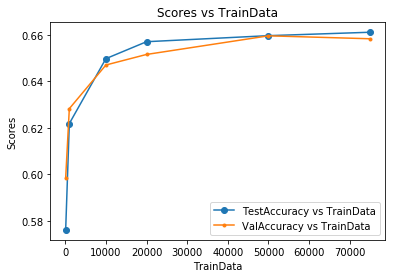

In [23]:
accuracyVisualization(train_samples,val_accuracies,test_accuracies)

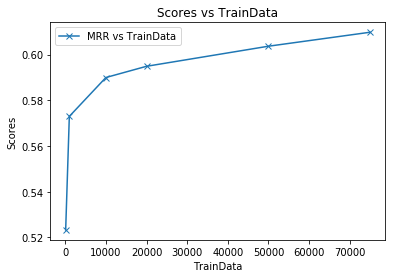

In [24]:
mrrVisualization(train_samples,mrr_vals)

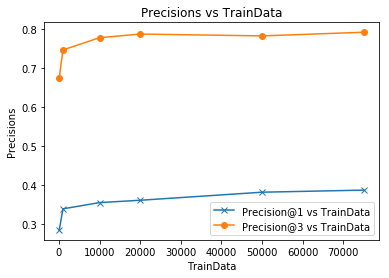

In [25]:
precisionVisualization(train_samples,p1s,p3s)

In [26]:
val_accuracies,test_accuracies,mrr_vals,p1s,p3s

([0.5985333333333334,
  0.6282666666666666,
  0.647,
  0.6515333333333333,
  0.6595333333333333,
  0.6582666666666667],
 [0.5762,
  0.6218666666666667,
  0.6497333333333334,
  0.657,
  0.6596,
  0.6610666666666667],
 [0.5232777777777788,
  0.5729333333333361,
  0.5899333333333352,
  0.5948444444444466,
  0.6036238095238123,
  0.6097349206349232],
 [0.286, 0.34, 0.356, 0.362, 0.38266666666666665, 0.388],
 [0.6766666666666666,
  0.7473333333333333,
  0.7786666666666666,
  0.788,
  0.7833333333333333,
  0.7926666666666666])